In [2]:
!pip install Sastrawi

In [3]:
# import libraries yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import warnings
warnings.filterwarnings('ignore')

# library buat text preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# library buat machine learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# download data dari NLTK buat teknisasi NLP
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

print("All libraries imported successfully!")

All libraries imported successfully!


In [4]:
# function buat load data review
def load_review_data():
    """Load review data from available CSV files"""
    reviews_data = []

    # Cari file CSV di direktori root
    import os
    import glob

    # Cari file CSV yang mengandung 'review' dalam nama file
    review_files = glob.glob('reviews_*.csv')

    # Jika tidak ada file yang ditemukan, coba cari file dengan 'Review' (making sure, terutama jika tiba-tiba nama file berubah)
    if not review_files:
        review_files = glob.glob('*review*.csv') + glob.glob('*Review*.csv')
        # Hapus duplikasi file yang terbaca (jika ada)
        review_files = list(set(review_files))

    # Fallback: jika tidak ada file yang ditemukan, gunakan semua file tipe CSV di direktori
    if not review_files:
        all_csv_files = glob.glob('*.csv')
        if all_csv_files:
            print("No files with 'review' in the name found. Available CSV files:")
            for file in all_csv_files:
                print(f"  - {file}")
            print("\nUsing all CSV files found:")
            review_files = all_csv_files
        else:
            print("No CSV files found in the current directory.")
            return reviews_data

    print(f"Found {len(review_files)} CSV file(s) to process:")
    for file in review_files:
        print(f"  - {file}")
    print()

    for file in review_files:
        try:
            # Baca file CSV temuan
            df_temp = pd.read_csv(file, encoding='utf-8')

            # Ekstrak nama produk dari nama file (ini bisa maksimalkan proses ekstraksi)
            product_name = file.replace('.csv', '')
            if product_name.startswith('reviews_'):
                product_name = product_name[8:] # => Hapus prefix 'reviews_'

            # Bersihkan nama produk (hapus timestamp dan underscores)
            import re
            # Hapus pola timestamp (YYYYMMDD_HHMMSS)
            product_name = re.sub(r'_\d{8}_\d{6}$', '', product_name)
            # Ganti underscores dengan spasi
            product_name = product_name.replace('_', ' ')

            # Filtering: hanya teks yang benar-benar teks ulasan
            # Skip jika ada kolom yang (sepertinya) dari metadata atau memang tidak relevan
            if 'review' in df_temp.columns:
                # Ini hapus row yang terlalu pendek atau punya pola yang seperti auto-generated.
                df_temp = df_temp[df_temp['review'].notna()]
                df_temp = df_temp[df_temp['review'].str.len() > 10] # => Review minimal 10 karakter (kalo kepanjangan, masih gagal terfilter)
                df_temp = df_temp[~df_temp['review'].str.contains('Key Benefits|Users have reported', na=False)]

            # Convert DataFrame to list of dictionaries
            # Ubah dari DataFrame ke list of dicts (supaya ringan)
            for _, row in df_temp.iterrows():
                review_dict = row.to_dict()
                review_dict['product'] = product_name
                reviews_data.append(review_dict)

            print(f"Loaded {len(df_temp)} reviews from '{product_name}'")
            print(f"Columns in {file}: {df_temp.columns.tolist()}")

        except FileNotFoundError:
            print(f"File {file} not found")
        except Exception as e:
            print(f"Error loading {file}: {e}")
            print(f"Invalid encoding or file format.")

    return reviews_data

# Load data
reviews_data = load_review_data()
print(f"\nTotal reviews loaded: {len(reviews_data)}")

if reviews_data:
    # Convert ke DataFrame untuk analisis lebih lanjut
    df = pd.DataFrame(reviews_data)
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Tampilkan informasi dasar data
    if 'review' in df.columns:
        print(f"\nReview text statistics:")
        print(f"- Average review length: {df['review'].str.len().mean():.1f} characters")
        print(f"- Min review length: {df['review'].str.len().min()} characters")
        print(f"- Max review length: {df['review'].str.len().max()} characters")

    # Tampilkan beberapa baris pertama dari DataFrame (validation matters!)
    print(f"\nFirst few rows:")
    display(df.head(3))

    # Tampilkan tipe data masing-masing kolom
    print(f"\nData types:")
    print(df.dtypes)
else:
    print("No data loaded. Please check your CSV files.")
    df = pd.DataFrame()  # => Fallback: buat DataFrame kosong jika tidak ada data

Found 2 CSV file(s) to process:
  - reviews_MSH Niacinamide Brightening Moisture Gel_20250703_191020.csv
  - reviews_Skintific 5X Ceramide Barrier Repair Moisture Gel Moisturizer_20250702_231421.csv

Loaded 1144 reviews from 'MSH Niacinamide Brightening Moisture Gel'
Columns in reviews_MSH Niacinamide Brightening Moisture Gel_20250703_191020.csv: ['review', 'page', 'scraped_at']
Loaded 1144 reviews from 'MSH Niacinamide Brightening Moisture Gel'
Columns in reviews_MSH Niacinamide Brightening Moisture Gel_20250703_191020.csv: ['review', 'page', 'scraped_at']
Loaded 1527 reviews from 'Skintific 5X Ceramide Barrier Repair Moisture Gel Moisturizer'
Columns in reviews_Skintific 5X Ceramide Barrier Repair Moisture Gel Moisturizer_20250702_231421.csv: ['review', 'page', 'scraped_at']

Total reviews loaded: 2671
DataFrame shape: (2671, 4)
Columns: ['review', 'page', 'scraped_at', 'product']

Review text statistics:
- Average review length: 252.6 characters
- Min review length: 11 characters
- 

review  page  \
0  Moisturizer ini benar-benar jadi holy grail bu...     1   
1  awalnya sih bagus bagus aja, tapi entah kenapa...     1   
2  Dibandingkan dengan moisturizer yang warna bir...     1   

                   scraped_at                                   product  
0  2025-07-03T19:04:50.899164  MSH Niacinamide Brightening Moisture Gel  
1  2025-07-03T19:04:50.899222  MSH Niacinamide Brightening Moisture Gel  
2  2025-07-03T19:04:50.899246  MSH Niacinamide Brightening Moisture Gel


Data types:
review        object
page           int64
scraped_at    object
product       object
dtype: object


In [5]:
# Text Preprocessing Class
class IndonesianTextPreprocessor:
    def __init__(self):
        # Inisiasi stemmer dan stopword remover untuk Bahasa Indonesia
        factory = StemmerFactory()
        self.stemmer = factory.create_stemmer()

        stop_factory = StopWordRemoverFactory()
        self.stopword_remover = stop_factory.create_stop_word_remover()

        # Additional Indonesian stopwords
        self.additional_stopwords = {
            'yang', 'ini', 'itu', 'dengan', 'untuk', 'dari', 'ke', 'di', 'pada', 'oleh',
            'saya', 'aku', 'kamu', 'dia', 'mereka', 'kita', 'kalian',
            'sangat', 'sekali', 'banget', 'bgt', 'sih', 'deh', 'dong', 'loh', 'kok',
            'produk', 'skincare', 'wajah', 'kulit', 'moisturizer', 'gel'
        }

    def clean_text(self, text):
        """Clean and normalize text"""
        if pd.isna(text) or text == '':
            return ''

        # Convert kata ke lowercase
        text = str(text).lower()

        # Hapus URL (jika ada)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Hapus email address (jika ada)
        text = re.sub(r'\S+@\S+', '', text)

        # Hapus angka dan karakter khusus (kaya emoticon atau puctuations), sisakan kata dan spasi
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # hapus whitespace yang berlebih
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_text(self, text):
        """Tokenize text into words"""
        if not text:
            return []

        # Tokenisasi sederhana (dipisahin dari spasi)
        tokens = text.split()

        # filter token yang kependekan
        tokens = [token for token in tokens if len(token) >= 4 and len(token) <= 25]

        return tokens

    def remove_stopwords(self, tokens):
        """Remove stopwords from tokens"""
        # Gabungkan token menjadi string untuk stopword removal dengan Sastrawi
        text = ' '.join(tokens)
        text = self.stopword_remover.remove(text)

        # Pisahkan lagi token dan hapus stopwords tambahan
        # (Sastrawi sudah menghapus stopwords umum, tapi kita tambahkan yang spesifik)
        # (Misalnya: 'produk', 'skincare', 'wajah', dll
        tokens = text.split()
        tokens = [token for token in tokens if token not in self.additional_stopwords]

        return tokens

    def stem_tokens(self, tokens):
        """Apply stemming to tokens"""
        # Gabungkan token untuk proses stemming
        text = ' '.join(tokens)
        stemmed_text = self.stemmer.stem(text)

        return stemmed_text.split()

    def preprocess(self, text, include_stemming=True):
        """Complete preprocessing pipeline"""
        # bersihkan teks
        cleaned_text = self.clean_text(text)

        # tokenisasi
        tokens = self.tokenize_text(cleaned_text)

        # hapus stopwords
        tokens = self.remove_stopwords(tokens)

        # lakukan stemming - optional (default selalu true)
        if include_stemming:
            tokens = self.stem_tokens(tokens)

        # kembalikan ke string
        processed_text = ' '.join(tokens)

        return processed_text

# Inisiasi preprocessor
preprocessor = IndonesianTextPreprocessor()

# Lakukan preprocessing pada contoh review
if len(df) > 0:
    sample_text = df['review'].iloc[0] if 'review' in df.columns else str(df.iloc[0, 0])
    print("Original text:")
    print(sample_text)
    print("\nProcessed text:")
    print(preprocessor.preprocess(sample_text))
else:
    print("No data available for testing")

Original text:
Moisturizer ini benar-benar jadi holy grail buat aku yang cari pelembap ringan tapi ada plus-nya! Teksturnya nyaman banget di kulit, nggak bikin berat sama sekali dan cepat meresap sempurna. Setiap kali pakai, kulit langsung terasa lembab tanpa ada rasa lengket atau greasy. Yang paling aku suka, moisturizer ini juga kasih efek mencerahkan sedikit di wajah. Nggak instan yang bikin putih banget, tapi perlahan kulitku jadi kelihatan lebih cerah dan merata warnanya.

Processed text:
benar benar jadi holy grail buat cari lembap ringan plus tekstur nyaman bikin berat sama cepat resap sempurna kali pakai langsung asa lembab rasa lengket greasy paling suka kasih efek cerah sedikit instan bikin putih perlahan kulit jadi lihat lebih cerah rata warna
benar benar jadi holy grail buat cari lembap ringan plus tekstur nyaman bikin berat sama cepat resap sempurna kali pakai langsung asa lembab rasa lengket greasy paling suka kasih efek cerah sedikit instan bikin putih perlahan kulit jad

In [6]:
class AdvancedIndonesianSentimentLabeler:
    def __init__(self):
        # === SENTIMEN KATA UNIGRAM ===
        # Bank kata positif dengan skor intensitas (1.0 = normal, 2.0 = sangat positif)
        self.positive_words = {
            # Kata positif umum
            'bagus': 1.0, 'baik': 1.0, 'suka': 1.0, 'senang': 1.0, 'puas': 1.5, 'mantap': 1.5,
            'keren': 1.0, 'oke': 0.8, 'cocok': 1.2, 'recommended': 1.5, 'recommend': 1.5,

            # Kata positif intensif (English)
            'love': 2.0, 'amazing': 2.0, 'perfect': 2.0, 'excellent': 2.0, 'good': 1.0,
            'great': 1.5, 'awesome': 2.0, 'fantastic': 2.0, 'wonderful': 2.0,

            # Kata positif untuk skincare/moisturizer
            'lembut': 1.2, 'halus': 1.2, 'wangi': 1.0, 'fresh': 1.2, 'nyaman': 1.2,
            'mudah': 1.0, 'cepat': 1.0, 'efektif': 1.5, 'moisturizing': 1.5, 'hydrating': 1.5,
            'melembabkan': 1.5, 'mencerahkan': 1.5, 'melembutkan': 1.2,

            # Kata positif berkaitan dengan harga
            'terjangkau': 1.0, 'murah': 1.0, 'worth': 1.2, 'worthed': 1.2,
            'satisfied': 1.5, 'worthy': 1.2,

            # Kata intensitas tinggi (Indonesian slang)
            'banget': 1.5, 'bgt': 1.5, 'sekali': 1.3, 'poll': 2.0, 'parah': 1.8
        }

        # Bank kata negatif dengan skor intensitas
        self.negative_words = {
            # Kata negatif umum
            'jelek': 1.0, 'buruk': 1.5, 'benci': 2.0, 'kecewa': 1.5, 'zonk': 1.8,
            'mengecewakan': 1.5, 'gagal': 1.5, 'fail': 1.5,

            # Kata negatif intensif (English)
            'disappointed': 1.5, 'bad': 1.0, 'terrible': 2.0, 'awful': 2.0, 'worst': 2.0,
            'hate': 2.0, 'horrible': 2.0, 'disgusting': 2.0,

            # Kata yang bermakna 'masalah'
            'problem': 1.2, 'masalah': 1.2, 'error': 1.5, 'trouble': 1.2,

            # Kata negatif spesifik skincare
            'breakout': 1.5, 'iritasi': 1.5, 'gatal': 1.2, 'perih': 1.3, 'panas': 1.0,
            'berminyak': 1.0, 'lengket': 1.0, 'berat': 0.8, 'sulit': 1.0, 'susah': 1.0,
            'bruntusan': 1.5, 'jerawat': 1.2, 'minyak': 1.5,

            # Kata negatif berkaitan dengan harga
            'mahal': 1.0, 'expensive': 1.0, 'overpriced': 1.5, 'kemahalan': 1.2
        }

        # === POLA SENTIMEN BIGRAM/TRIGRAM ===
        # Pola n-gram positif (frasa yang menunjukkan sentimen positif)
        self.positive_ngrams = {
            # Bigrams
            'sangat bagus': 2.0, 'sangat baik': 2.0, 'sangat cocok': 2.0, 'sangat puas': 2.5,
            'sangat suka': 2.0, 'benar benar': 1.5, 'bener bener': 1.5, 'worth hype': 2.0,
            'highly recommended': 2.5, 'very good': 2.0, 'so good': 2.0, 'really good': 2.0,
            'cepat meresap': 1.5, 'mudah meresap': 1.5, 'tidak lengket': 1.2, 'ringan banget': 1.5,
            'cocok banget': 2.0, 'bagus banget': 2.0, 'love banget': 2.5, 'suka banget': 2.0, 'holy grail': 2.5,

            # Trigrams
            'sangat sangat bagus': 2.5, 'benar benar bagus': 2.0, 'worth the hype': 2.0,
            'sangat cocok banget': 2.5, 'bagus banget sih': 2.0, 'recommended banget deh': 2.5
        }

        # Pola n-gram negatif
        self.negative_ngrams = {
            # Bigrams
            'sangat buruk': 2.0, 'sangat jelek': 2.0, 'sangat kecewa': 2.5, 'very bad': 2.0,
            'so bad': 2.0, 'really bad': 2.0, 'tidak cocok': 1.5, 'gak cocok': 1.5,
            'bikin bruntusan': 2.0, 'bikin jerawat': 1.8, 'malah bruntusan': 2.0,
            'jadi bruntusan': 1.8, 'breakout parah': 2.5, 'iritasi parah': 2.5,
            'totally disappointed': 2.5, 'waste money': 2.0, 'buang uang': 2.0, 'bruntusan parah': 2.5,

            # Trigrams
            'sangat sangat buruk': 2.5, 'benar benar kecewa': 2.5, 'totally waste money': 2.5,
            'malah jadi bruntusan': 2.0, 'bikin muka bruntusan': 2.0, 'bruntusan parah banget': 2.5,
        }

        # === HANDLING NEGASI ===
        # Kata-kata negasi yang bisa membalikkan sentimen
        self.negation_words = {
            'tidak', 'nggak', 'gak', 'ga', 'bukan', 'never', 'no', 'nothing',
            'enggak', 'ndak', 'nda', 'kagak', 'kaga', 'tapi'
        }

        # === KATA PENGUAT SENTIMEN ===
        # Kata-kata yang memperkuat sentimen
        self.intensifiers = {
            'sangat': 1.5, 'sekali': 1.3, 'banget': 1.5, 'bgt': 1.5, 'very': 1.5,
            'really': 1.5, 'so': 1.3, 'super': 1.8, 'ultra': 1.8, 'extremely': 2.0,
            'totally': 1.8, 'absolutely': 2.0, 'definitely': 1.5,
            'benar': 1.3, 'bener': 1.3, 'beneran': 1.5, 'emang': 1.2, 'memang': 1.2
        }

        # === KATA PELEMAH SENTIMEN ===
        # Kata-kata yang melemahkan sentimen
        self.diminishers = {
            'agak': 0.7, 'sedikit': 0.7, 'lumayan': 0.8, 'cukup': 0.8, 'quite': 0.8,
            'rather': 0.7, 'somewhat': 0.7, 'biasa': 0.6, 'standar': 0.6,
            'kurang': 0.5, 'less': 0.7, 'little': 0.7
        }

    def extract_ngrams(self, words, n=2):
        """
        Ekstrak n-gram dari list kata
        n=2 untuk bigram, n=3 untuk trigram
        """
        ngrams = []
        for i in range(len(words) - n + 1):
            ngram = ' '.join(words[i:i+n])
            ngrams.append(ngram)
        return ngrams

    def calculate_sentiment_score(self, text):
        """
        Hitung skor sentimen dengan algoritma yang lebih canggih
        Menggunakan unigram, bigram, trigram, dan context analysis
        """
        if not text:
            return 0.0

        words = text.lower().split()
        if len(words) == 0:
            return 0.0

        # === KALKULASI SKOR ===
        positive_score = 0.0
        negative_score = 0.0

        # === 1. ANALISIS N-GRAM ===
        # Analisis bigram dan trigram terlebih dahulu (prioritas tinggi)
        # analisis trigram
        trigrams = self.extract_ngrams(words, 3)
        for trigram in trigrams:
            if trigram in self.positive_ngrams:
                positive_score += self.positive_ngrams[trigram]
            elif trigram in self.negative_ngrams:
                negative_score += self.negative_ngrams[trigram]

        # analisis bigram
        bigrams = self.extract_ngrams(words, 2)
        for bigram in bigrams:
            if bigram in self.positive_ngrams:
                positive_score += self.positive_ngrams[bigram]
            elif bigram in self.negative_ngrams:
                negative_score += self.negative_ngrams[bigram]

        # === 2. ANALISIS UNIGRAM DENGAN KONTEKS ===
        negated = False
        intensifier_multiplier = 1.0
        diminisher_multiplier = 1.0

        for i, word in enumerate(words):
            # reset modifiers setiap beberapa kata untuk mencegah efek jarak jauh
            if i > 0 and i % 4 == 0:
                negated = False
                intensifier_multiplier = 1.0
                diminisher_multiplier = 1.0

            # Cek negasi
            if word in self.negation_words:
                negated = True
                continue

            # Cek kata penguat sentimen (intensifier)
            if word in self.intensifiers:
                intensifier_multiplier = max(intensifier_multiplier, self.intensifiers[word])
                continue

            # Cek kata pelemah sentimen (diminisher)
            if word in self.diminishers:
                diminisher_multiplier = min(diminisher_multiplier, self.diminishers[word])
                continue

            # Hitung skor sentimen untuk kata
            current_score = 0.0

            if word in self.positive_words:
                current_score = self.positive_words[word]
                # implement modifiers
                current_score *= intensifier_multiplier * diminisher_multiplier

                if negated:
                    # Negasi membalik sentimen dan mengurangi intensitas
                    negative_score += current_score * 0.8
                else:
                    positive_score += current_score

            elif word in self.negative_words:
                current_score = self.negative_words[word]
                # implement modifiers
                current_score *= intensifier_multiplier * diminisher_multiplier

                if negated:
                    # Negasi membalik sentimen
                    positive_score += current_score * 0.8
                else:
                    negative_score += current_score

            # Reset negasi setelah proses selesai
            if current_score > 0:
                negated = False

        # === 3. Adjustment berdasarkan konteks ===
        # Adjustment berdasarkan panjang teks
        text_length_factor = min(1.0, len(words) / 10.0)  # => Normalisasi untuk teks pendek

        # === 4. HITUNG SKOR FINAL ===
        # Hitung net sentiment score
        net_score = (positive_score - negative_score) * text_length_factor

        return net_score

    def label_sentiment(self, text, threshold_positive=0.5, threshold_negative=-0.9):
        """
        Label sentiment dengan threshold yang dapat disesuaikan
        Menggunakan scoring yang lebih sophisticated
        """
        sentiment_score = self.calculate_sentiment_score(text)

        # === KLASIFIKASI SENTIMEN ===
        if sentiment_score >= threshold_positive:
            return 'positive'
        elif sentiment_score <= threshold_negative:
            return 'negative'
        else:
            # === KLASIFIKASI NEUTRAL ===
            words = text.lower().split()

            # Cek pola n-gram yang netral
            neutral_indicators = ['ok', 'oke', 'biasa', 'standar', 'cukup', 'lumayan']
            if any(indicator in text.lower() for indicator in neutral_indicators):
                return 'neutral'

            # Anggap teks yang lebih pendek dari 3 karakter (jika ada) sebagai netral
            # supaya tidak mengganggu analisis
            if len(words) < 3:
                return 'neutral'

            # Jika tidak ada kata sentiment yang kuat, klasifikasi sebagai neutral
            return 'neutral'

    def get_sentiment_details(self, text):
        """
        Memberikan detail analisis sentiment untuk debugging dan insight
        """
        sentiment_score = self.calculate_sentiment_score(text)
        sentiment_label = self.label_sentiment(text)

        words = text.lower().split()

        # Analisis komponen
        bigrams = self.extract_ngrams(words, 2)
        trigrams = self.extract_ngrams(words, 3)

        found_positive_words = [word for word in words if word in self.positive_words]
        found_negative_words = [word for word in words if word in self.negative_words]
        found_positive_ngrams = [ng for ng in bigrams + trigrams if ng in self.positive_ngrams]
        found_negative_ngrams = [ng for ng in bigrams + trigrams if ng in self.negative_ngrams]

        return {
            'sentiment': sentiment_label,
            'score': sentiment_score,
            'positive_words': found_positive_words,
            'negative_words': found_negative_words,
            'positive_ngrams': found_positive_ngrams,
            'negative_ngrams': found_negative_ngrams,
            'word_count': len(words)
        }

# Inisiasi labeler sentimen
print("Initialize sentiment labeller...")
sentiment_labeler = AdvancedIndonesianSentimentLabeler()

# Test dengan beberapa contoh untuk memastikan kinerja
print("\n=== TESTING ADVANCED SENTIMENT LABELER ===")
test_examples = [
    "Produk ini sangat bagus banget dan cocok untuk kulit saya",
    "Sangat kecewa dengan produk ini, bikin bruntusan parah",
    "Lumayan sih, tidak terlalu bagus tapi juga tidak buruk",
    "Amazing product! Highly recommended for sensitive skin",
    "Gak cocok di kulit saya, malah jadi bruntusan",
    "Benar benar worth the hype, love banget sama produk ini"
]

for i, example in enumerate(test_examples, 1):
    details = sentiment_labeler.get_sentiment_details(example)
    print(f"\n{i}. '{example}'")
    print(f"   Sentiment: {details['sentiment']} (Score: {details['score']:.2f})")
    if details['positive_words']:
        print(f"   Positive words: {details['positive_words']}")
    if details['negative_words']:
        print(f"   Negative words: {details['negative_words']}")
    if details['positive_ngrams']:
        print(f"   Positive n-grams: {details['positive_ngrams']}")
    if details['negative_ngrams']:
        print(f"   Negative n-grams: {details['negative_ngrams']}")

# Apply advanced preprocessing and sentiment labeling to the dataset
# Aplikasikan preprocessing dan sentiment labeling ke dataset
if len(df) > 0:
    # Ambil kolom ulasan
    text_column = None
    for col in df.columns:
        if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower():
            text_column = col
            break

    if text_column is None:
        # Gunakan kolom string pertama
        for col in df.columns:
            if df[col].dtype == 'object':
                text_column = col
                break

    if text_column:
        print(f"\n=== PROCESSING DATASET ===")
        print(f"Using column '{text_column}' for sentiment analysis")

        # Implementasi preprocessing (sudah ada processed_text dari cell sebelumnya)
        if 'processed_text' not in df.columns:
            print("Applying text preprocessing...")
            df['processed_text'] = df[text_column].apply(lambda x: preprocessor.preprocess(str(x)))

        # Implement sentiment labeling with only positive and negative classes
        print("Applying advanced sentiment labeling...")
        
        # Modify the sentiment labeler to return only positive/negative (no neutral)
        def binary_sentiment_label(text):
            sentiment_score = sentiment_labeler.calculate_sentiment_score(text)
            # Use a simpler threshold - anything >= 0 is positive, < 0 is negative
            if sentiment_score >= 0:
                return 'positive'
            else:
                return 'negative'
        
        df['sentiment'] = df[text_column].apply(lambda x: binary_sentiment_label(str(x)))
        df['sentiment_score'] = df[text_column].apply(lambda x: sentiment_labeler.calculate_sentiment_score(str(x)))

        # Tampilkan hasil
        print(f"\nDataset shape after processing: {df.shape}")
        print(f"\nSentiment distribution (Binary Classification):")
        sentiment_counts = df['sentiment'].value_counts()
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {sentiment}: {count} ({percentage:.1f}%)")

        print(f"\nSentiment score statistics:")
        print(df['sentiment_score'].describe())

        # Tampilkan sample data dengan detail analisis
        print(f"\n=== SAMPLE PROCESSED DATA (dengan detail analisis) ===")
        sample_df = df[['product', text_column, 'processed_text', 'sentiment', 'sentiment_score']].head(3)
        for idx, row in sample_df.iterrows():
            print(f"\nProduct: {row['product']}")
            print(f"Original: {row[text_column][:100]}...")
            print(f"Processed: {row['processed_text'][:50]}...")
            print(f"Sentiment: {row['sentiment']} (Score: {row['sentiment_score']:.2f})")

            # Tampilkan detail analisis untuk data pertama
            if idx == sample_df.index[0]:
                details = sentiment_labeler.get_sentiment_details(row[text_column])
                if details['positive_words'] or details['negative_words']:
                    print(f"Detail Analysis:")
                    if details['positive_words']:
                        print(f"  - Positive words found: {details['positive_words']}")
                    if details['negative_words']:
                        print(f"  - Negative words found: {details['negative_words']}")
                    if details['positive_ngrams']:
                        print(f"  - Positive n-grams found: {details['positive_ngrams']}")
                    if details['negative_ngrams']:
                        print(f"  - Negative n-grams found: {details['negative_ngrams']}")
            print("-" * 60)
    else:
        print("No suitable text column found in the dataset")
else:
    print("No data available for processing")

Initialize sentiment labeller...

=== TESTING ADVANCED SENTIMENT LABELER ===

1. 'Produk ini sangat bagus banget dan cocok untuk kulit saya'
   Sentiment: positive (Score: 7.30)
   Positive words: ['bagus', 'banget', 'cocok']
   Positive n-grams: ['sangat bagus', 'bagus banget']

2. 'Sangat kecewa dengan produk ini, bikin bruntusan parah'
   Sentiment: negative (Score: -7.16)
   Positive words: ['parah']
   Negative words: ['kecewa', 'bruntusan']
   Negative n-grams: ['sangat kecewa', 'bikin bruntusan', 'bruntusan parah']

3. 'Lumayan sih, tidak terlalu bagus tapi juga tidak buruk'
   Sentiment: neutral (Score: -0.45)
   Positive words: ['bagus']
   Negative words: ['buruk']

4. 'Amazing product! Highly recommended for sensitive skin'
   Sentiment: positive (Score: 4.20)
   Positive words: ['amazing', 'recommended']
   Positive n-grams: ['highly recommended']

5. 'Gak cocok di kulit saya, malah jadi bruntusan'
   Sentiment: negative (Score: -6.21)
   Positive words: ['cocok']
   Negati

=== BINARY SENTIMENT DATA EXPLORATION ===


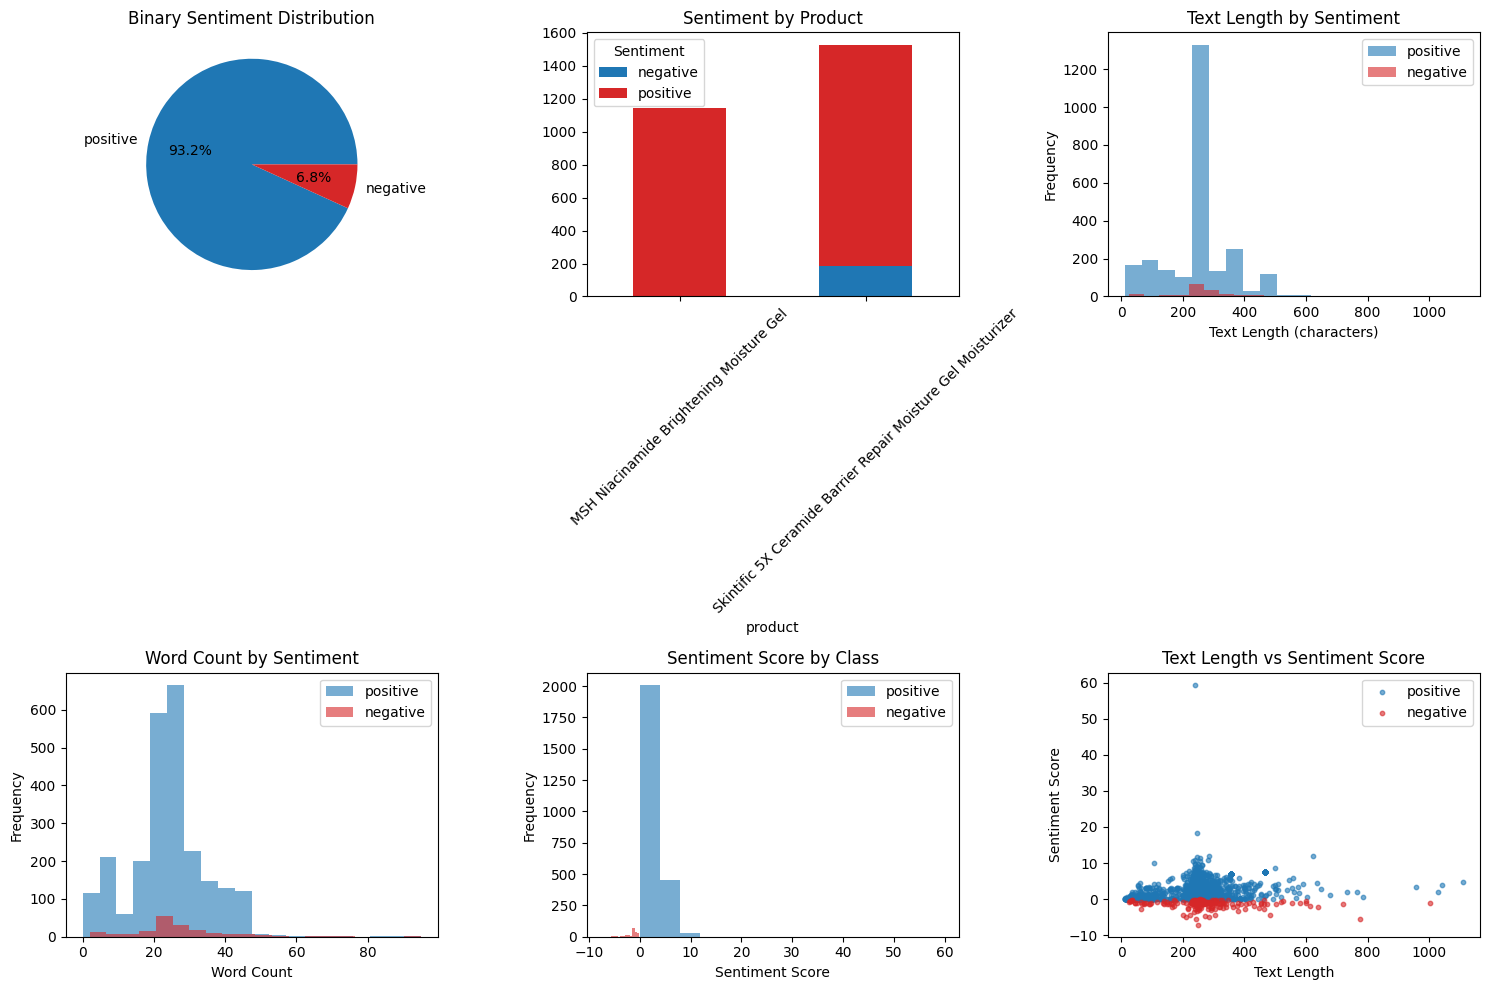


=== BINARY DATASET STATISTICS ===
Total reviews: 2671
Unique products: 2

Text length statistics:
count    2671.000000
mean      252.590041
std       110.684090
min        11.000000
25%       233.000000
50%       250.000000
75%       283.000000
max      1110.000000
Name: text_length, dtype: float64

Processed text length statistics:
count    2671.000000
mean      154.974167
std        68.247005
min         0.000000
25%       128.000000
50%       157.000000
75%       190.000000
max       610.000000
Name: processed_text, dtype: float64

Word count statistics:
count    2671.000000
mean       24.092849
std        10.883361
min         0.000000
25%        19.000000
50%        24.000000
75%        29.000000
max        95.000000
Name: word_count, dtype: float64

Binary sentiment distribution:
positive: 2489 (93.2%)
negative: 182 (6.8%)
=== GENERATING WORD CLOUDS (POSITIVE/NEGATIVE ONLY) ===


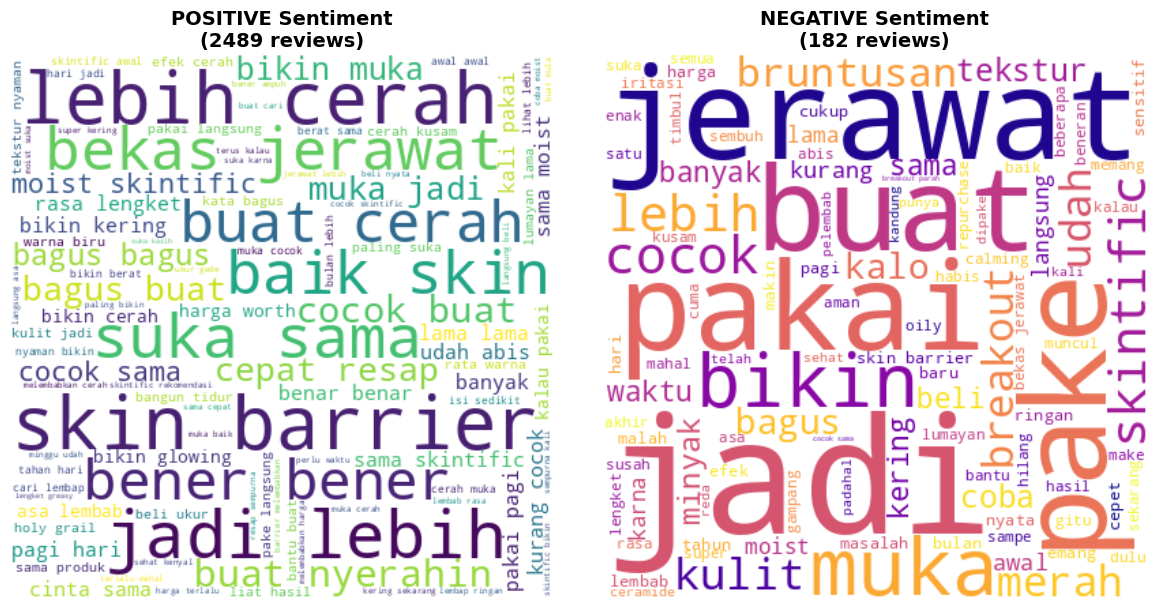

=== GENERATING ENHANCED SCATTER PLOTS (BINARY CLASSIFICATION) ===


In [7]:
# Explorasi dan visualisasi data - FOCUSED ON POSITIVE/NEGATIVE ONLY
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

def create_binary_wordclouds(df):
    """Create word clouds for positive and negative sentiment classes only"""
    print("=== GENERATING WORD CLOUDS (POSITIVE/NEGATIVE ONLY) ===")

    # Cek kolom yang diperlukan
    if 'processed_text' not in df.columns or 'sentiment' not in df.columns:
        print("Processed text or sentiment columns not found. Skipping word clouds.")
        return

    # Only process positive and negative sentiments
    sentiments = ['positive', 'negative']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    colors = ['viridis', 'plasma']  # Different colors for positive and negative
    
    for i, sentiment in enumerate(sentiments):
        # Dapatkan semua teks untuk sentimen ini
        sentiment_texts = df[df['sentiment'] == sentiment]['processed_text']
        all_text = ' '.join(sentiment_texts.dropna().astype(str))

        if len(all_text.strip()) > 0:
            # Generate word cloud
            wordcloud = WordCloud(
                width=400,
                height=400,
                background_color='white',
                max_words=100,
                colormap=colors[i],
                relative_scaling=0.5,
                random_state=42
            ).generate(all_text)

            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{sentiment.upper()} Sentiment\n({len(sentiment_texts)} reviews)',
                            fontsize=14, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'No data\nfor {sentiment}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{sentiment.upper()} Sentiment', fontsize=14)
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def create_enhanced_scatter_plots(df):
    """Create enhanced scatter plots for binary sentiment analysis with multiple visualizations"""
    print("=== GENERATING ENHANCED SCATTER PLOTS (BINARY CLASSIFICATION) ===")

    if 'processed_text' not in df.columns or 'sentiment' not in df.columns:
        print("Required columns not found. Skipping scatter plots.")
        return

    # Kalkulasi panjang teks dan jumlah kata untuk visualisasi
    df_plot = df.copy()
    df_plot['text_length'] = df_plot['processed_text'].str.len()
    df_plot['word_count'] = df_plot['processed_text'].str.split().str.len()

    # Buat subplots untuk visualisasi
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=(
            'Sentiment Score vs Text Length',
            'Word Count vs Text Length',
            'Sentiment Score vs Word Count',
            'Text Length Distribution by Sentiment',
            'Word Count Distribution by Sentiment',
            'Sentiment Score Distribution'
        ),
        specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
    )

    # Color mapping untuk positive dan negative
    color_map = {'positive': '#1f77b4', 'negative': '#d62728'}

    # 1. Skor sentimen vs Panjang teks (Enhanced scatter)
    if 'sentiment_score' in df_plot.columns:
        for sentiment in ['positive', 'negative']:
            mask = df_plot['sentiment'] == sentiment
            fig.add_trace(
                go.Scatter(
                    x=df_plot[mask]['text_length'],
                    y=df_plot[mask]['sentiment_score'],
                    mode='markers',
                    name=f'{sentiment}',
                    marker=dict(
                        color=color_map[sentiment], 
                        opacity=0.6,
                        size=6,
                        line=dict(width=1, color='white')
                    ),
                    hovertemplate='<b>%{text}</b><br>' +
                                'Text Length: %{x}<br>' +
                                'Sentiment Score: %{y:.2f}<extra></extra>',
                    text=[f'{sentiment}' for _ in range(mask.sum())]
                ),
                row=1, col=1
            )

    # 2. Word count vs panjang teks by sentimen
    for sentiment in ['positive', 'negative']:
        mask = df_plot['sentiment'] == sentiment
        fig.add_trace(
            go.Scatter(
                x=df_plot[mask]['text_length'],
                y=df_plot[mask]['word_count'],
                mode='markers',
                name=f'{sentiment} (word count)',
                marker=dict(
                    color=color_map[sentiment], 
                    opacity=0.6,
                    size=5,
                    symbol='diamond'
                ),
                hovertemplate='<b>%{text}</b><br>' +
                            'Text Length: %{x}<br>' +
                            'Word Count: %{y}<extra></extra>',
                text=[f'{sentiment}' for _ in range(mask.sum())],
                showlegend=False
            ),
            row=1, col=2
        )

    # 3. Sentiment Score vs Word Count (New visualization)
    if 'sentiment_score' in df_plot.columns:
        for sentiment in ['positive', 'negative']:
            mask = df_plot['sentiment'] == sentiment
            fig.add_trace(
                go.Scatter(
                    x=df_plot[mask]['word_count'],
                    y=df_plot[mask]['sentiment_score'],
                    mode='markers',
                    name=f'{sentiment} (score vs words)',
                    marker=dict(
                        color=color_map[sentiment], 
                        opacity=0.6,
                        size=5,
                        symbol='circle'
                    ),
                    hovertemplate='<b>%{text}</b><br>' +
                                'Word Count: %{x}<br>' +
                                'Sentiment Score: %{y:.2f}<extra></extra>',
                    text=[f'{sentiment}' for _ in range(mask.sum())],
                    showlegend=False
                ),
                row=1, col=3
            )

    # 4. Text Length Distribution by Sentiment
    for sentiment in ['positive', 'negative']:
        mask = df_plot['sentiment'] == sentiment
        fig.add_trace(
            go.Histogram(
                x=df_plot[mask]['text_length'],
                name=f'{sentiment} text length',
                opacity=0.7,
                marker_color=color_map[sentiment],
                nbinsx=25,
                showlegend=False
            ),
            row=2, col=1
        )

    # 5. Word Count Distribution by Sentiment
    for sentiment in ['positive', 'negative']:
        mask = df_plot['sentiment'] == sentiment
        fig.add_trace(
            go.Histogram(
                x=df_plot[mask]['word_count'],
                name=f'{sentiment} word count',
                opacity=0.7,
                marker_color=color_map[sentiment],
                nbinsx=25,
                showlegend=False
            ),
            row=2, col=2
        )

    # 6. Sentiment Score Distribution
    if 'sentiment_score' in df_plot.columns:
        for sentiment in ['positive', 'negative']:
            mask = df_plot['sentiment'] == sentiment
            fig.add_trace(
                go.Histogram(
                    x=df_plot[mask]['sentiment_score'],
                    name=f'{sentiment} score dist',
                    opacity=0.7,
                    marker_color=color_map[sentiment],
                    nbinsx=30,
                    showlegend=False
                ),
                row=2, col=3
            )

    # Update layout visualisasi
    fig.update_layout(
        title_text="Enhanced Binary Sentiment Analysis Visualizations",
        height=800,
        showlegend=True
    )

    # Perbarui label sumbu
    fig.update_xaxes(title_text="Text Length (characters)", row=1, col=1)
    fig.update_yaxes(title_text="Sentiment Score", row=1, col=1)

    fig.update_xaxes(title_text="Text Length (characters)", row=1, col=2)
    fig.update_yaxes(title_text="Word Count", row=1, col=2)

    fig.update_xaxes(title_text="Word Count", row=1, col=3)
    fig.update_yaxes(title_text="Sentiment Score", row=1, col=3)

    fig.update_xaxes(title_text="Text Length", row=2, col=1)
    fig.update_yaxes(title_text="Frequency", row=2, col=1)

    fig.update_xaxes(title_text="Word Count", row=2, col=2)
    fig.update_yaxes(title_text="Frequency", row=2, col=2)

    fig.update_xaxes(title_text="Sentiment Score", row=2, col=3)
    fig.update_yaxes(title_text="Frequency", row=2, col=3)

    fig.show()

def create_model_training_scatter_plots(model):
    """Create scatter plots specifically for model training results"""
    if not hasattr(model, 'is_trained') or not model.is_trained:
        print("Model not trained. Skipping model training scatter plots.")
        return

    print("=== GENERATING MODEL TRAINING SCATTER PLOTS ===")

    # dapatkan prediksi dan probabilitas untuk training set
    y_train_pred = model.model.predict(model.X_train_vectorized)
    y_train_pred_proba = model.model.predict_proba(model.X_train_vectorized)
    
    # dapatkan prediksi dan probabilitas untuk test set
    y_test_pred = model.model.predict(model.X_test_vectorized)
    y_test_pred_proba = model.model.predict_proba(model.X_test_vectorized)

    # Buat klasifikasi laporan
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Training Set: Prediction Confidence',
            'Test Set: Prediction Confidence', 
            'Training vs Test Accuracy by Confidence',
            'Prediction Probability Distribution'
        )
    )

    # Color mapping
    color_map = {'positive': '#1f77b4', 'negative': '#d62728'}

    # 1. Training Set Confidence Scatter
    train_max_probs = np.max(y_train_pred_proba, axis=1)
    train_correct = (y_train_pred == model.y_train)
    
    for sentiment in ['positive', 'negative']:
        mask = (model.y_train == sentiment)
        colors = ['green' if correct else 'red' for correct in train_correct[mask]]
        
        fig.add_trace(
            go.Scatter(
                x=np.where(mask)[0],
                y=train_max_probs[mask],
                mode='markers',
                marker=dict(color=colors, opacity=0.6, size=4),
                name=f'Train {sentiment}',
                hovertemplate='Sample: %{x}<br>' +
                            'Confidence: %{y:.3f}<br>' +
                            'Sentiment: ' + sentiment + '<extra></extra>'
            ),
            row=1, col=1
        )

    # 2. Test Set Confidence Scatter
    test_max_probs = np.max(y_test_pred_proba, axis=1)
    test_correct = (y_test_pred == model.y_test)
    
    for sentiment in ['positive', 'negative']:
        mask = (model.y_test == sentiment)
        colors = ['green' if correct else 'red' for correct in test_correct[mask]]
        
        fig.add_trace(
            go.Scatter(
                x=np.where(mask)[0],
                y=test_max_probs[mask],
                mode='markers',
                marker=dict(color=colors, opacity=0.6, size=4),
                name=f'Test {sentiment}',
                hovertemplate='Sample: %{x}<br>' +
                            'Confidence: %{y:.3f}<br>' +
                            'Sentiment: ' + sentiment + '<extra></extra>',
                showlegend=False
            ),
            row=1, col=2
        )

    # 3. Accuracy by Confidence Level
    confidence_bins = np.linspace(0.5, 1.0, 11)
    train_acc_by_conf = []
    test_acc_by_conf = []
    
    for i in range(len(confidence_bins)-1):
        min_conf, max_conf = confidence_bins[i], confidence_bins[i+1]
        
        # Training accuracy
        train_mask = (train_max_probs >= min_conf) & (train_max_probs < max_conf)
        if train_mask.sum() > 0:
            train_acc = train_correct[train_mask].mean()
        else:
            train_acc = 0
        train_acc_by_conf.append(train_acc)
        
        # Test accuracy
        test_mask = (test_max_probs >= min_conf) & (test_max_probs < max_conf)
        if test_mask.sum() > 0:
            test_acc = test_correct[test_mask].mean()
        else:
            test_acc = 0
        test_acc_by_conf.append(test_acc)
    
    bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
    
    fig.add_trace(
        go.Scatter(
            x=bin_centers,
            y=train_acc_by_conf,
            mode='lines+markers',
            name='Training Accuracy',
            line=dict(color='blue'),
            marker=dict(size=6)
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=bin_centers,
            y=test_acc_by_conf,
            mode='lines+markers',
            name='Test Accuracy',
            line=dict(color='red'),
            marker=dict(size=6)
        ),
        row=2, col=1
    )

    # 4. Prediction Probability Distribution
    # For binary classification, show probability distribution for each class
    for i, sentiment in enumerate(['positive', 'negative']):
        # Get probabilities for this class
        class_probs = y_test_pred_proba[:, i]
        
        fig.add_trace(
            go.Histogram(
                x=class_probs,
                name=f'{sentiment} probability',
                opacity=0.7,
                marker_color=color_map[sentiment],
                nbinsx=30
            ),
            row=2, col=2
        )

    # Update layout
    fig.update_layout(
        title_text="Model Training and Testing Performance Analysis",
        height=800,
        showlegend=True
    )

    # Update axes labels
    fig.update_xaxes(title_text="Sample Index", row=1, col=1)
    fig.update_yaxes(title_text="Prediction Confidence", row=1, col=1)
    
    fig.update_xaxes(title_text="Sample Index", row=1, col=2)
    fig.update_yaxes(title_text="Prediction Confidence", row=1, col=2)
    
    fig.update_xaxes(title_text="Confidence Level", row=2, col=1)
    fig.update_yaxes(title_text="Accuracy", row=2, col=1)
    
    fig.update_xaxes(title_text="Probability", row=2, col=2)
    fig.update_yaxes(title_text="Frequency", row=2, col=2)

    fig.show()

def explore_binary_sentiment_data(df):
    """Enhanced exploration and visualization focusing on binary sentiment data"""
    if len(df) == 0:
        print("No data to explore")
        return

    print("=== BINARY SENTIMENT DATA EXPLORATION ===")

    # Traditional plots - focused on positive/negative only
    plt.figure(figsize=(15, 10))

    # 1. Sentiment distribution (pie chart) - only positive/negative
    plt.subplot(2, 3, 1)
    sentiment_counts = df['sentiment'].value_counts()
    colors = ['#1f77b4', '#d62728']  # Blue for positive, red for negative
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors)
    plt.title('Binary Sentiment Distribution')

    # 2. Sentiment by product (if available)
    plt.subplot(2, 3, 2)
    if 'product' in df.columns:
        sentiment_product = pd.crosstab(df['product'], df['sentiment'])
        sentiment_product.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors)
        plt.title('Sentiment by Product')
        plt.xticks(rotation=45)
        plt.legend(title='Sentiment')

    # 3. Text length distribution by sentiment
    plt.subplot(2, 3, 3)
    text_col = None
    for col in df.columns:
        if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower():
            text_col = col
            break

    if text_col:
        df['text_length'] = df[text_col].astype(str).str.len()
        for i, sentiment in enumerate(['positive', 'negative']):
            subset = df[df['sentiment'] == sentiment]['text_length']
            plt.hist(subset, alpha=0.6, label=sentiment, bins=20, color=colors[i])
        plt.title('Text Length by Sentiment')
        plt.xlabel('Text Length (characters)')
        plt.ylabel('Frequency')
        plt.legend()

    # 4. Word count distribution by sentiment
    plt.subplot(2, 3, 4)
    if 'processed_text' in df.columns:
        df['word_count'] = df['processed_text'].str.split().str.len()
        for i, sentiment in enumerate(['positive', 'negative']):
            subset = df[df['sentiment'] == sentiment]['word_count']
            plt.hist(subset, alpha=0.6, label=sentiment, bins=20, color=colors[i])
        plt.title('Word Count by Sentiment')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.legend()

    # 5. Sentiment score distribution
    plt.subplot(2, 3, 5)
    if 'sentiment_score' in df.columns:
        for i, sentiment in enumerate(['positive', 'negative']):
            subset = df[df['sentiment'] == sentiment]['sentiment_score']
            plt.hist(subset, alpha=0.6, label=sentiment, bins=15, color=colors[i])
        plt.title('Sentiment Score by Class')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Frequency')
        plt.legend()

    # 6. Text Length vs Sentiment Score scatter plot
    plt.subplot(2, 3, 6)
    if 'text_length' in df.columns and 'sentiment_score' in df.columns:
        for i, sentiment in enumerate(['positive', 'negative']):
            mask = df['sentiment'] == sentiment
            plt.scatter(df[mask]['text_length'], df[mask]['sentiment_score'],
                       alpha=0.6, label=sentiment, s=10, color=colors[i])
        plt.title('Text Length vs Sentiment Score')
        plt.xlabel('Text Length')
        plt.ylabel('Sentiment Score')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Print statistics - focused on binary classification
    print("\n=== BINARY DATASET STATISTICS ===")
    print(f"Total reviews: {len(df)}")
    print(f"Unique products: {df['product'].nunique() if 'product' in df.columns else 'N/A'}")

    if text_col and 'text_length' in df.columns:
        print(f"\nText length statistics:")
        print(df['text_length'].describe())

    if 'processed_text' in df.columns:
        processed_length = df['processed_text'].str.len()
        print(f"\nProcessed text length statistics:")
        print(processed_length.describe())

        print(f"\nWord count statistics:")
        print(df['word_count'].describe())

    print(f"\nBinary sentiment distribution:")
    for sentiment, count in df['sentiment'].value_counts().items():
        percentage = (count / len(df)) * 100
        print(f"{sentiment}: {count} ({percentage:.1f}%)")

    # Generate binary word clouds
    create_binary_wordclouds(df)

    # Generate enhanced scatter plots
    create_enhanced_scatter_plots(df)

# Run the enhanced exploration focused on binary classification
if len(df) > 0:
    explore_binary_sentiment_data(df)
else:
    print("No data available for visualization")

In [8]:
import random
import nltk
from nltk.corpus import wordnet
import pandas as pd

# Ensure necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

class SentimentAugmenter:
    def __init__(self):
        pass

    def synonym_replacement(self, text, n=1):
        words = text.split()
        new_words = words.copy()
        eligible_words = [w for w in words if wordnet.synsets(w)]
        if not eligible_words:
            return text

        random.shuffle(eligible_words)
        replaced = 0
        for word in eligible_words:
            synsets = wordnet.synsets(word)
            synonyms = set()
            for syn in synsets:
                for lemma in syn.lemmas():
                    synonym = lemma.name().replace('_', ' ')
                    if synonym.lower() != word.lower():
                        synonyms.add(synonym)
            if synonyms:
                chosen = random.choice(list(synonyms))
                new_words = [chosen if w == word else w for w in new_words]
                replaced += 1
            if replaced >= n:
                break
        return ' '.join(new_words)

    def random_deletion(self, text, p=0.1):
        words = text.split()
        if len(words) == 1:
            return text
        new_words = [w for w in words if random.uniform(0, 1) > p]
        if not new_words:
            return random.choice(words)
        return ' '.join(new_words)

    def template_augmentation(self, product_name="produk"):
        templates = [
            f"Saya kecewa dengan {product_name}.",
            f"{product_name} sangat tidak sesuai deskripsi.",
            f"Pengiriman lambat, kualitas {product_name} jelek.",
            f"Tidak akan beli {product_name} lagi.",
            f"{product_name} membuat saya sangat kecewa."
        ]
        return random.choice(templates)

    def augment_negative_review(self, text, product_name="produk"):
        augmented = set()
        augmented.add(self.synonym_replacement(text, n=1))
        augmented.add(self.random_deletion(text, p=0.1))
        augmented.add(self.template_augmentation(product_name))
        return list(augmented)

    def augment_dataset(self, df, target_label='negative', augmentations_per_sample=3, product_name="produk"):
        df_target = df[df['sentiment'] == target_label]
        augmented_rows = []
        for _, row in df_target.iterrows():
            augments = self.augment_negative_review(row['processed_text'], product_name)
            for aug in augments[:augmentations_per_sample]:
                augmented_rows.append({
                    'processed_text': aug,
                    'sentiment': target_label
                })
        df_augmented = pd.DataFrame(augmented_rows)
        return df_augmented


[nltk_data] Downloading package wordnet to /home/luji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/luji/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
augmenter = SentimentAugmenter()

# Generate augmented data for binary classification (focus on balancing positive/negative)
print("=== DATA AUGMENTATION FOR BINARY CLASSIFICATION ===")

# Check current distribution
print("Current sentiment distribution:")
current_dist = df['sentiment'].value_counts()
for sentiment, count in current_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {sentiment}: {count} ({percentage:.1f}%)")

# Determine which class needs augmentation
min_class = current_dist.min()
max_class = current_dist.max()
minority_class = current_dist.idxmin()

print(f"\nMinority class: {minority_class} ({min_class} samples)")
print(f"Majority class: {current_dist.idxmax()} ({max_class} samples)")

# Generate augmented data for the minority class
augmentations_needed = max_class - min_class
print(f"augmentation needed: {augmentations_needed} samples")
augmentations_per_sample = max(1, augmentations_needed // min_class)

print(f"Generating {augmentations_per_sample} augmentations per {minority_class} sample...")

df_augmented = augmenter.augment_dataset(
    df, 
    target_label=minority_class, 
    augmentations_per_sample=augmentations_per_sample
)

# Combine with original dataset
df_with_augmented = pd.concat([df, df_augmented]).reset_index(drop=True)

print(f"\nAugmentation results:")
print(f"Original samples: {len(df)}")
print(f"Augmented samples added: {len(df_augmented)}")
print(f"Total dataset size: {len(df_with_augmented)}")

print(f"\nFinal sentiment distribution:")
final_dist = df_with_augmented['sentiment'].value_counts()
for sentiment, count in final_dist.items():
    percentage = (count / len(df_with_augmented)) * 100
    print(f"  {sentiment}: {count} ({percentage:.1f}%)")

# Calculate balance improvement
balance_ratio_before = min_class / max_class
balance_ratio_after = final_di-st.min() / final_dist.max()
print(f"\nBalance improvement:")
print(f"Before augmentation: {balance_ratio_before:.3f}")
print(f"After augmentation: {balance_ratio_after:.3f}")
print(f"Improvement: {(balance_ratio_after - balance_ratio_before):.3f}")


=== DATA AUGMENTATION FOR BINARY CLASSIFICATION ===
Current sentiment distribution:
  positive: 2489 (93.2%)
  negative: 182 (6.8%)

Minority class: negative (182 samples)
Majority class: positive (2489 samples)
augmentation needed: 2307 samples
Generating 12 augmentations per negative sample...

Augmentation results:
Original samples: 2671
Augmented samples added: 536
Total dataset size: 3207

Final sentiment distribution:
  positive: 2489 (77.6%)
  negative: 718 (22.4%)

Balance improvement:
Before augmentation: 0.073
After augmentation: 0.288
Improvement: 0.215

Augmentation results:
Original samples: 2671
Augmented samples added: 536
Total dataset size: 3207

Final sentiment distribution:
  positive: 2489 (77.6%)
  negative: 718 (22.4%)

Balance improvement:
Before augmentation: 0.073
After augmentation: 0.288
Improvement: 0.215


All required packages are available!
Initializing binary sentiment analysis model with enhanced visualizations...
Prepared 3206 samples for training
Original class distribution: positive    2488
negative     718
Name: count, dtype: int64
Performing 5-fold cross-validation with class balancing...
Cross-validation scores: [0.88629283 0.88923557 0.90327613 0.89079563 0.87363495]
Mean CV accuracy: 0.8886 (+/- 0.0190)

Training the final binary classification model with 70/30 split...
Training set size: 2244 (70%)
Test set size: 962 (30%)
Vectorizing text data...

=== APPLYING CLASS BALANCING FOR BINARY CLASSIFICATION ===
Original training distribution: positive    1741
negative     503
Name: count, dtype: int64

Applying SMOTE oversampling for binary classification...
Cross-validation scores: [0.88629283 0.88923557 0.90327613 0.89079563 0.87363495]
Mean CV accuracy: 0.8886 (+/- 0.0190)

Training the final binary classification model with 70/30 split...
Training set size: 2244 (70%)
Test se

=== GENERATING MODEL TRAINING SCATTER PLOTS ===


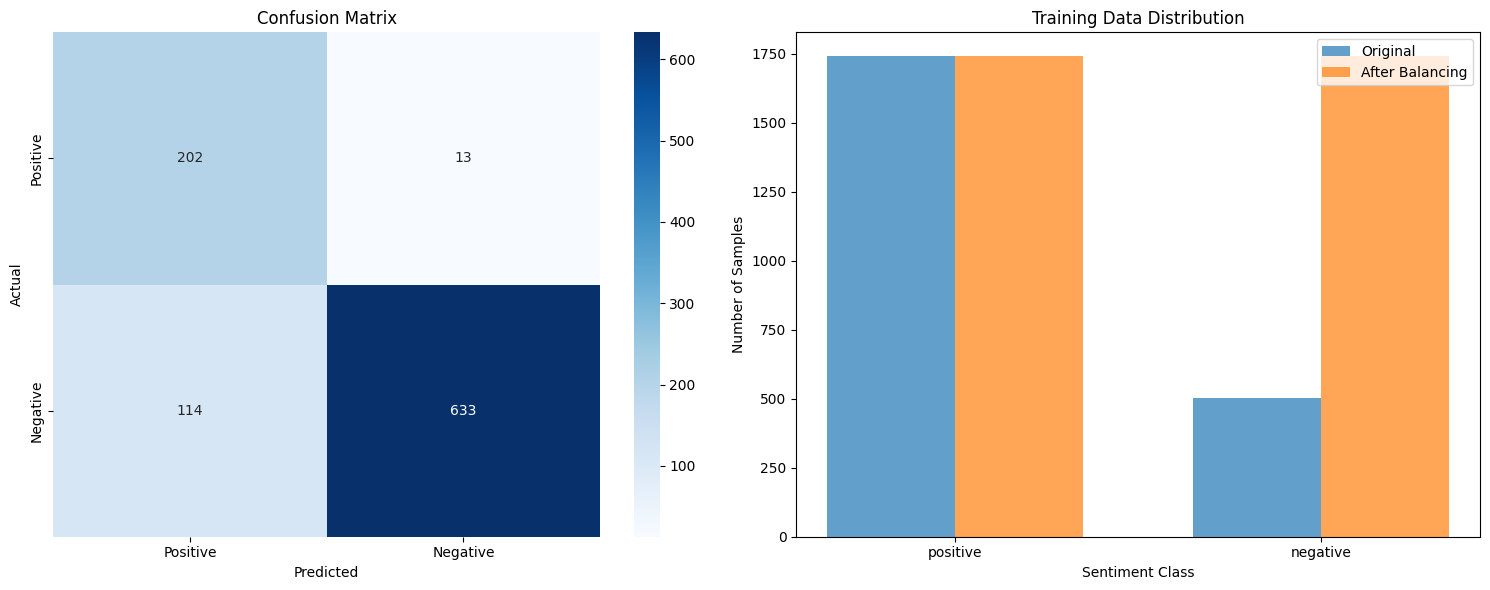

=== GENERATING PERFORMANCE WORD CLOUDS (BINARY CLASSIFICATION) ===


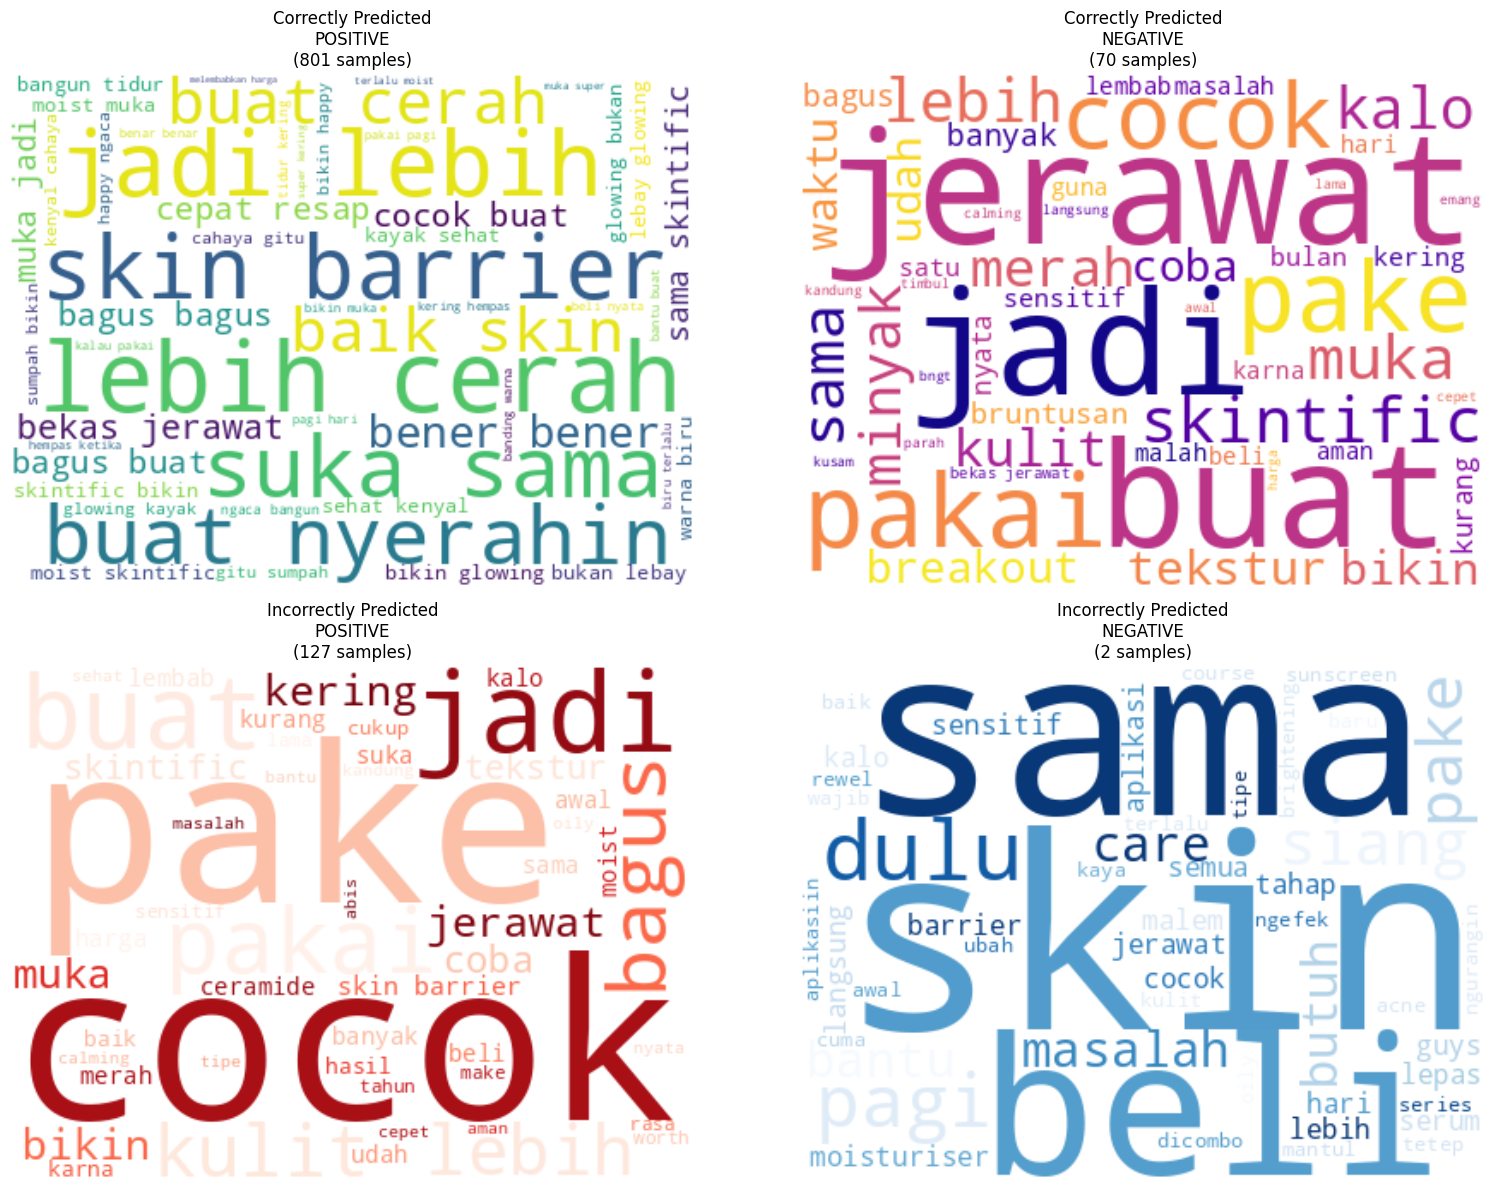


=== TOP FEATURES BY CLASS ===

Top 15 features for negative:
  produk: -4.7437
  jerawat: -4.7957
  sangat: -5.2961
  pakai: -5.3340
  kecewa: -5.5091
  breakout: -5.5266
  pake: -5.5478
  jadi: -5.5937
  sangat tidak: -5.6278
  sesuai deskripsi: -5.6278
  tidak sesuai: -5.6278
  produk sangat: -5.6278
  deskripsi: -5.6278
  bruntusan: -5.6357
  jelek: -5.6605

Top 15 features for positive:
  buat: -5.0788
  bikin: -5.2158
  muka: -5.2460
  cerah: -5.2900
  jadi: -5.4102
  bagus: -5.4376
  lebih: -5.4565
  sama: -5.4833
  cocok: -5.5082
  pakai: -5.5612
  skin: -5.5774
  kusam: -5.5953
  kering: -5.5965
  pake: -5.6075
  moist: -5.6087

=== BINARY CLASSIFICATION SUMMARY ===
Classification type: Binary (Positive vs Negative)
SMOTE used: True
Class weights used: True
Class weights: {'negative': np.float64(1.0), 'positive': np.float64(1.0)}
Original training samples: 2244
Balanced training samples: 3482


In [10]:
# MultinomialNB Sentiment Analysis Model with Class Balancing and Enhanced Visualizations
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class SentimentAnalysisModel:
    def __init__(self, vectorizer_type='tfidf', max_features=5000, ngram_range=(1, 2), use_smote=True, use_class_weights=True):
        """
        Initialize the sentiment analysis model with class balancing options

        Parameters:
        - vectorizer_type: 'tfidf' or 'count'
        - max_features: maximum number of features to extract
        - ngram_range: tuple indicating n-gram range (e.g., (1,1) for unigrams, (1,2) for unigrams+bigrams)
        - use_smote: whether to use SMOTE for oversampling minority classes
        - use_class_weights: whether to use class weights for balancing
        """
        self.vectorizer_type = vectorizer_type
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.use_smote = use_smote
        self.use_class_weights = use_class_weights

        # Initialize vectorizer
        if vectorizer_type == 'tfidf':
            self.vectorizer = TfidfVectorizer(
                max_features=max_features,
                ngram_range=ngram_range,
                stop_words=None,  # We already removed stopwords
                lowercase=False,  # Already lowercased
                token_pattern=r'\b\w+\b'
            )
        else:
            self.vectorizer = CountVectorizer(
                max_features=max_features,
                ngram_range=ngram_range,
                stop_words=None,
                lowercase=False,
                token_pattern=r'\b\w+\b'
            )

        # Initialize MultinomialNB (class_weight will be set during training)
        self.model = MultinomialNB()

        # Create pipeline
        self.pipeline = Pipeline([
            ('vectorizer', self.vectorizer),
            ('classifier', self.model)
        ])

        self.is_trained = False
        self.smote = None
        self.class_weights = None

    def prepare_data(self, df, text_column='processed_text', target_column='sentiment'):
        """Prepare data for training"""
        # Filter out empty texts
        df_clean = df.dropna(subset=[text_column, target_column])
        df_clean = df_clean[df_clean[text_column].str.strip() != '']

        X = df_clean[text_column].values
        y = df_clean[target_column].values

        print(f"Prepared {len(X)} samples for training")
        print(f"Original class distribution: {pd.Series(y).value_counts()}")

        return X, y

    def apply_class_balancing(self, X_train_vectorized, y_train):
        """Apply class balancing techniques for binary classification"""
        print("\n=== APPLYING CLASS BALANCING FOR BINARY CLASSIFICATION ===")

        original_distribution = pd.Series(y_train).value_counts()
        print(f"Original training distribution: {original_distribution}")

        X_balanced = X_train_vectorized
        y_balanced = y_train

        # For binary classification, use SMOTE if classes are imbalanced
        if self.use_smote:
            print("\nApplying SMOTE oversampling for binary classification...")
            
            # Check if we have enough samples for SMOTE
            min_class_size = min(original_distribution.values)
            if min_class_size > 5:  # Need at least 6 samples for default k_neighbors=5
                k_neighbors = min(5, min_class_size - 1)
                
                self.smote = SMOTE(
                    sampling_strategy='auto',  # Balance all classes to match majority class
                    random_state=42,
                    k_neighbors=k_neighbors
                )

                try:
                    X_balanced, y_balanced = self.smote.fit_resample(X_train_vectorized, y_train)
                    balanced_distribution = pd.Series(y_balanced).value_counts()
                    print(f"After SMOTE distribution: {balanced_distribution}")
                    print(f"Total samples after SMOTE: {len(y_balanced)} (was {len(y_train)})")
                except Exception as e:
                    print(f"SMOTE failed: {e}")
                    print("Using random undersampling instead...")
                    self.use_smote = False
                    
            else:
                print("Insufficient samples for SMOTE. Using random undersampling...")
                self.use_smote = False

        # Fallback: random undersampling for binary classification
        if not self.use_smote:
            print("\nApplying random undersampling...")
            
            # Get indices by class
            class_indices = {}
            for class_name in original_distribution.index:
                class_indices[class_name] = np.where(y_train == class_name)[0]
            
            # Find the minority class size
            min_class_size = min(len(indices) for indices in class_indices.values())
            
            # Sample equally from all classes
            rng = np.random.default_rng(seed=42)
            sampled_indices = []
            
            for class_name, indices in class_indices.items():
                if len(indices) > min_class_size:
                    sampled = rng.choice(indices, size=min_class_size, replace=False)
                else:
                    sampled = indices
                sampled_indices.extend(sampled)
            
            # Shuffle the combined indices
            rng.shuffle(sampled_indices)
            
            # Apply to X and y
            X_balanced = X_train_vectorized[sampled_indices]
            y_balanced = y_train[sampled_indices]
            
            balanced_distribution = pd.Series(y_balanced).value_counts()
            print(f"After undersampling distribution: {balanced_distribution}")
            print(f"Total samples after undersampling: {len(y_balanced)} (was {len(y_train)})")

        # Calculate class weights if enabled
        if self.use_class_weights:
            print("\nCalculating class weights...")
            unique_classes = np.unique(y_balanced)
            class_weights = compute_class_weight(
                class_weight='balanced',
                classes=unique_classes,
                y=y_balanced
            )
            self.class_weights = dict(zip(unique_classes, class_weights))
            print(f"Class weights: {self.class_weights}")

            # Reset model (MultinomialNB doesn't support class_weight directly)
            self.model = MultinomialNB()

        return X_balanced, y_balanced

    def calculate_sample_weights(self, y):
        """Calculate sample weights based on class weights"""
        if not self.use_class_weights or self.class_weights is None:
            return None

        sample_weights = np.array([self.class_weights[label] for label in y])
        return sample_weights

    def train(self, X, y, test_size=0.3, random_state=42):
        """Train the model with class balancing - using 70/30 split for better SMOTE performance"""
        # Split data with 70/30 split (better for SMOTE with imbalanced data)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        print(f"Training set size: {len(X_train)} (70%)")
        print(f"Test set size: {len(X_test)} (30%)")

        # Vectorize the text data
        print("Vectorizing text data...")
        X_train_vectorized = self.vectorizer.fit_transform(X_train)
        X_test_vectorized = self.vectorizer.transform(X_test)

        # Apply class balancing
        X_train_balanced, y_train_balanced = self.apply_class_balancing(X_train_vectorized, y_train)

        # Calculate sample weights
        sample_weights = self.calculate_sample_weights(y_train_balanced)

        # Train the model
        print("\nTraining MultinomialNB model with balanced data...")
        if sample_weights is not None:
            self.model.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)
            print("Training completed with sample weights!")
        else:
            self.model.fit(X_train_balanced, y_train_balanced)
            print("Training completed!")

        # Update the pipeline with the trained components
        self.pipeline = Pipeline([
            ('vectorizer', self.vectorizer),
            ('classifier', self.model)
        ])

        self.is_trained = True

        # Store data for evaluation (use original test set, not balanced)
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.X_test_vectorized = X_test_vectorized
        self.X_train_vectorized = X_train_vectorized

        # Store balanced training data for analysis
        self.X_train_balanced = X_train_balanced
        self.y_train_balanced = y_train_balanced

        return X_train, X_test, y_train, y_test

    def create_performance_wordclouds(self, df):
        """Create word clouds for correctly and incorrectly predicted samples - Binary Classification"""
        if not self.is_trained:
            print("Model not trained. Cannot create performance word clouds.")
            return

        print("=== GENERATING PERFORMANCE WORD CLOUDS (BINARY CLASSIFICATION) ===")

        # Get predictions for the original dataset
        text_col = 'processed_text' if 'processed_text' in df.columns else 'review'
        if text_col not in df.columns:
            print("No suitable text column found.")
            return

        # Get predictions for a sample of the data
        sample_size = min(1000, len(df))  # Limit for performance
        df_sample = df.sample(n=sample_size, random_state=42)

        predictions = self.pipeline.predict(df_sample[text_col])
        correct_mask = predictions == df_sample['sentiment'].values

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Only process positive and negative sentiments
        sentiments = ['positive', 'negative']
        
        for i, sentiment in enumerate(sentiments):
            # Correctly predicted
            correct_sentiment = df_sample[correct_mask & (df_sample['sentiment'] == sentiment)]
            if len(correct_sentiment) > 0:
                text = ' '.join(correct_sentiment[text_col].astype(str))
                if len(text.strip()) > 0:
                    colormap = 'viridis' if sentiment == 'positive' else 'plasma'
                    wordcloud = WordCloud(width=400, height=300, background_color='white',
                                        colormap=colormap, max_words=50).generate(text)
                    axes[0, i].imshow(wordcloud, interpolation='bilinear')
                    axes[0, i].set_title(f'Correctly Predicted\n{sentiment.upper()}\n({len(correct_sentiment)} samples)')
                else:
                    axes[0, i].text(0.5, 0.5, 'No data', ha='center', va='center')
                    axes[0, i].set_title(f'Correctly Predicted {sentiment.upper()}')
            else:
                axes[0, i].text(0.5, 0.5, 'No data', ha='center', va='center')
                axes[0, i].set_title(f'Correctly Predicted {sentiment.upper()}')
            axes[0, i].axis('off')

            # Incorrectly predicted
            incorrect_sentiment = df_sample[~correct_mask & (df_sample['sentiment'] == sentiment)]
            if len(incorrect_sentiment) > 0:
                text = ' '.join(incorrect_sentiment[text_col].astype(str))
                if len(text.strip()) > 0:
                    colormap = 'Reds' if sentiment == 'positive' else 'Blues'
                    wordcloud = WordCloud(width=400, height=300, background_color='white',
                                        colormap=colormap, max_words=50).generate(text)
                    axes[1, i].imshow(wordcloud, interpolation='bilinear')
                    axes[1, i].set_title(f'Incorrectly Predicted\n{sentiment.upper()}\n({len(incorrect_sentiment)} samples)')
                else:
                    axes[1, i].text(0.5, 0.5, 'No data', ha='center', va='center')
                    axes[1, i].set_title(f'Incorrectly Predicted {sentiment.upper()}')
            else:
                axes[1, i].text(0.5, 0.5, 'No data', ha='center', va='center')
                axes[1, i].set_title(f'Incorrectly Predicted {sentiment.upper()}')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    def create_interactive_performance_plots(self):
        """Create interactive plots for binary classification model performance analysis"""
        if not self.is_trained:
            print("Model not trained. Cannot create performance plots.")
            return

        print("=== GENERATING INTERACTIVE PERFORMANCE PLOTS (BINARY CLASSIFICATION) ===")

        # Get predictions and probabilities
        y_pred = self.model.predict(self.X_test_vectorized)
        y_pred_proba = self.model.predict_proba(self.X_test_vectorized)
        max_probs = np.max(y_pred_proba, axis=1)

        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Prediction Confidence Distribution',
                'Binary Classification ROC-style Analysis',
                'Class Performance Metrics',
                'Confusion Matrix Heatmap'
            ),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"type": "bar"}, {"secondary_y": False}]]
        )

        # 1. Prediction Confidence Distribution
        correct_predictions = (y_pred == self.y_test)
        color_map = {'positive': '#1f77b4', 'negative': '#d62728'}

        fig.add_trace(
            go.Histogram(
                x=max_probs[correct_predictions],
                name='Correct Predictions',
                opacity=0.7,
                marker_color='green',
                nbinsx=30
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Histogram(
                x=max_probs[~correct_predictions],
                name='Incorrect Predictions',
                opacity=0.7,
                marker_color='red',
                nbinsx=30
            ),
            row=1, col=1
        )

        # 2. Prediction Probabilities by True Class
        for i, sentiment in enumerate(['positive', 'negative']):
            mask = (self.y_test == sentiment)
            probs_for_class = y_pred_proba[mask, i]  # Probability of predicting this class
            
            fig.add_trace(
                go.Scatter(
                    x=np.where(mask)[0],
                    y=probs_for_class,
                    mode='markers',
                    name=f'True {sentiment}',
                    marker=dict(
                        color=color_map[sentiment],
                        opacity=0.6,
                        size=4
                    ),
                    hovertemplate=f'Sample: %{{x}}<br>P({sentiment}): %{{y:.3f}}<extra></extra>'
                ),
                row=1, col=2
            )

        # 3. Class Performance Metrics
        from sklearn.metrics import classification_report
        class_report = classification_report(self.y_test, y_pred, output_dict=True)

        metrics = ['precision', 'recall', 'f1-score']
        classes = ['positive', 'negative']

        for metric in metrics:
            values = [class_report[cls][metric] for cls in classes if cls in class_report]
            fig.add_trace(
                go.Bar(
                    x=classes,
                    y=values,
                    name=metric.capitalize(),
                    opacity=0.8
                ),
                row=2, col=1
            )

        # 4. Confusion Matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(self.y_test, y_pred)

        fig.add_trace(
            go.Heatmap(
                z=cm,
                x=['positive', 'negative'],
                y=['positive', 'negative'],
                colorscale='Blues',
                text=cm,
                texttemplate="%{text}",
                textfont={"size": 12},
                showscale=True
            ),
            row=2, col=2
        )

        # Update layout
        fig.update_layout(
            title_text="Interactive Binary Classification Performance Analysis",
            height=800,
            showlegend=True
        )

        # Update axes
        fig.update_xaxes(title_text="Confidence Score", row=1, col=1)
        fig.update_yaxes(title_text="Frequency", row=1, col=1)

        fig.update_xaxes(title_text="Sample Index", row=1, col=2)
        fig.update_yaxes(title_text="Prediction Probability", row=1, col=2)

        fig.update_xaxes(title_text="Classes", row=2, col=1)
        fig.update_yaxes(title_text="Score", row=2, col=1)

        fig.update_xaxes(title_text="Predicted", row=2, col=2)
        fig.update_yaxes(title_text="Actual", row=2, col=2)

        fig.show()

    def evaluate(self):
        """Evaluate the binary classification model with enhanced visualizations"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return

        # Predictions on original training set
        y_train_pred = self.model.predict(self.X_train_vectorized)
        train_accuracy = accuracy_score(self.y_train, y_train_pred)

        # Predictions on test set
        y_test_pred = self.model.predict(self.X_test_vectorized)
        test_accuracy = accuracy_score(self.y_test, y_test_pred)

        print("=== BINARY CLASSIFICATION MODEL EVALUATION ===")
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        print(f"\n=== CLASSIFICATION REPORT (Test Set) ===")
        print(classification_report(self.y_test, y_test_pred))

        # Detailed per-class analysis for binary classification
        print(f"\n=== BINARY CLASSIFICATION PERFORMANCE ANALYSIS ===")
        class_report = classification_report(self.y_test, y_test_pred, output_dict=True)

        for class_name in ['positive', 'negative']:
            if class_name in class_report:
                metrics = class_report[class_name]
                support = metrics['support']
                print(f"\n{class_name.upper()}:")
                print(f"  Precision: {metrics['precision']:.4f} (of predicted {class_name}, {metrics['precision']*100:.1f}% were correct)")
                print(f"  Recall: {metrics['recall']:.4f} (detected {metrics['recall']*100:.1f}% of actual {class_name} reviews)")
                print(f"  F1-score: {metrics['f1-score']:.4f}")
                print(f"  Support: {support} samples")

        # Confusion Matrix
        print(f"\n=== CONFUSION MATRIX ===")
        cm = confusion_matrix(self.y_test, y_test_pred)
        print("        Predicted")
        print("       Pos  Neg")
        print(f"Pos  {cm[0,0]:4d} {cm[0,1]:4d}")
        print(f"Neg  {cm[1,0]:4d} {cm[1,1]:4d}")

        # Create enhanced visualizations
        self.create_interactive_performance_plots()
        
        # Add model training scatter plots
        create_model_training_scatter_plots(self)

        # Traditional matplotlib plots for comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Positive', 'Negative'],
                   yticklabels=['Positive', 'Negative'], ax=ax1)
        ax1.set_title('Confusion Matrix')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')

        # Class distribution comparison
        original_dist = pd.Series(self.y_train).value_counts()
        balanced_dist = pd.Series(self.y_train_balanced).value_counts()

        x = range(len(original_dist))
        width = 0.35

        ax2.bar([i - width/2 for i in x], original_dist.values, width, label='Original', alpha=0.7)
        ax2.bar([i + width/2 for i in x], balanced_dist.values, width, label='After Balancing', alpha=0.7)
        ax2.set_xlabel('Sentiment Class')
        ax2.set_ylabel('Number of Samples')
        ax2.set_title('Training Data Distribution')
        ax2.set_xticks(x)
        ax2.set_xticklabels(original_dist.index)
        ax2.legend()

        plt.tight_layout()
        plt.show()

        return {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'classification_report': class_report,
            'confusion_matrix': cm
        }

    def cross_validate(self, X, y, cv=5):
        """Perform cross-validation with balanced data"""
        print(f"Performing {cv}-fold cross-validation with class balancing...")

        # Create a temporary pipeline for cross-validation
        temp_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(
                max_features=self.max_features,
                ngram_range=self.ngram_range,
                stop_words=None,
                lowercase=False,
                token_pattern=r'\b\w+\b'
            )),
            ('classifier', MultinomialNB())
        ])

        cv_scores = cross_val_score(temp_pipeline, X, y, cv=cv, scoring='accuracy')

        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        return cv_scores

    def predict(self, texts):
        """Make predictions on new texts"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return None

        if isinstance(texts, str):
            texts = [texts]

        # Use the pipeline for predictions (ensures consistent preprocessing)
        predictions = self.pipeline.predict(texts)
        return predictions

    def predict_proba(self, texts):
        """Get prediction probabilities"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return None

        if isinstance(texts, str):
            texts = [texts]

        # Use the pipeline for predictions
        probabilities = self.pipeline.predict_proba(texts)
        return probabilities

    def predict_with_details(self, texts):
        """Make predictions with detailed output including probabilities"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return None

        if isinstance(texts, str):
            texts = [texts]

        predictions = self.pipeline.predict(texts)
        probabilities = self.pipeline.predict_proba(texts)
        classes = self.pipeline.classes_

        results = []
        for i, text in enumerate(texts):
            prob_dict = {class_name: prob for class_name, prob in zip(classes, probabilities[i])}
            result = {
                'text': text,
                'predicted_sentiment': predictions[i],
                'probabilities': prob_dict,
                'confidence': max(probabilities[i])
            }
            results.append(result)

        return results

    def plot_sentiment_score_distribution(self, df, text_column='processed_text', target_column='sentiment'):
      """
      Plot sentiment score distribution by true sentiment.
      """
      df = df.copy()
      df['calculated_sentiment_score'] = df[text_column].apply(
          lambda x: sentiment_labeler.calculate_sentiment_score(x)
      )

      import seaborn as sns
      import matplotlib.pyplot as plt

      plt.figure(figsize=(10, 6))
      sns.histplot(data=df, x='calculated_sentiment_score', hue=target_column, bins=50, kde=True)
      plt.title('Sentiment Score Distribution by True Sentiment')
      plt.xlabel('Sentiment Score')
      plt.ylabel('Frequency')
      plt.show()

      return df  # Return df so you can reuse it for threshold tuning

    def tune_negative_threshold(self, df_scored, target_column='sentiment', thresholds=np.arange(-1.0, 0.0, 0.05)):
      """
      Find the best negative threshold balancing precision and recall.
      """
      from sklearn.metrics import precision_score, recall_score, f1_score

      results = []

      for thresh in thresholds:
          y_pred = []
          for score in df_scored['calculated_sentiment_score']:
              if score <= thresh:
                  y_pred.append('negative')
              else:
                  y_pred.append('neutral_or_positive')

          # Create binary labels for evaluation
          y_true_binary = (df_scored[target_column] == 'negative').astype(int)
          y_pred_binary = (np.array(y_pred) == 'negative').astype(int)

          precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
          recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
          f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

          results.append({
              'threshold': thresh,
              'precision': precision,
              'recall': recall,
              'f1': f1
          })

      results_df = pd.DataFrame(results)

      # Plot precision-recall curve
      import matplotlib.pyplot as plt
      plt.figure(figsize=(8, 6))
      plt.plot(results_df['threshold'], results_df['precision'], label='Precision', marker='o')
      plt.plot(results_df['threshold'], results_df['recall'], label='Recall', marker='o')
      plt.plot(results_df['threshold'], results_df['f1'], label='F1-score', marker='o')
      plt.xlabel('Negative Threshold')
      plt.ylabel('Score')
      plt.title('Threshold Tuning for Negative Sentiment')
      plt.legend()
      plt.grid(True)
      plt.show()

      best_row = results_df.loc[results_df['f1'].idxmax()]
      print(f"Best threshold by F1: {best_row['threshold']:.2f}")
      print(f"Precision: {best_row['precision']:.2f}, Recall: {best_row['recall']:.2f}, F1: {best_row['f1']:.2f}")

      return results_df

    def get_feature_importance(self, top_n=15):
        """Get most important features for each class"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return

        feature_names = self.vectorizer.get_feature_names_out()

        # Get feature log probabilities for each class
        feature_log_prob = self.model.feature_log_prob_
        class_labels = self.model.classes_

        print("=== TOP FEATURES BY CLASS ===")

        for i, class_label in enumerate(class_labels):
            print(f"\nTop {top_n} features for {class_label}:")
            # Get indices of top features for this class
            top_indices = feature_log_prob[i].argsort()[-top_n:][::-1]

            for idx in top_indices:
                feature_name = feature_names[idx]
                log_prob = feature_log_prob[i][idx]
                print(f"  {feature_name}: {log_prob:.4f}")

# Check if required packages are available
try:
    import imblearn
    from wordcloud import WordCloud
    import plotly.graph_objects as go
    print("All required packages are available!")
except ImportError as e:
    print(f"Missing package: {e}")
    print("Please install missing packages...")

# Train the model with class balancing if we have data
if len(df) > 0 and 'processed_text' in df.columns and 'sentiment' in df.columns:
    print("Initializing binary sentiment analysis model with enhanced visualizations...")
    model = SentimentAnalysisModel(
        vectorizer_type='tfidf',
        max_features=3000,
        ngram_range=(1, 2),
        use_smote=True,
        use_class_weights=True
    )

    # Prepare data using augmented dataset for better balance
    X, y = model.prepare_data(df_with_augmented)

    # Cross-validation first
    cv_scores = model.cross_validate(X, y, cv=5)

    # Train the model with 70/30 split
    print("\nTraining the final binary classification model with 70/30 split...")
    X_train, X_test, y_train, y_test = model.train(X, y, test_size=0.3)

    # Evaluate the model with enhanced visualizations
    print("\nEvaluating the binary classification model with enhanced visualizations...")
    evaluation_results = model.evaluate()

    # Create performance word clouds
    model.create_performance_wordclouds(df)

    # Show feature importance
    print("\n" + "="*50)
    model.get_feature_importance(top_n=15)

    print("\n" + "="*50)
    print("=== BINARY CLASSIFICATION SUMMARY ===")
    print(f"Classification type: Binary (Positive vs Negative)")
    print(f"SMOTE used: {model.use_smote}")
    print(f"Class weights used: {model.use_class_weights}")
    print(f"Class weights: {model.class_weights}")
    print(f"Original training samples: {len(model.y_train)}")
    print(f"Balanced training samples: {len(model.y_train_balanced)}")

else:
    print("No data available for training!")

In [13]:
# Comprehensive Binary Classification Model Testing and Analysis
def test_binary_model_predictions(model, preprocessor):
    """Test binary classification model with sample predictions"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    # Sample test texts (in Indonesian and English) with expected binary results
    test_texts = [
        ("Produk ini sangat bagus dan membuat kulit saya lembut sekali", "positive"),
        ("Saya tidak suka produk ini karena membuat kulit berminyak", "negative"),
        ("Amazing product! Highly recommended for sensitive skin", "positive"),
        ("Terrible product, caused breakout on my skin", "negative"),
        ("Moisturizer ini cocok banget untuk kulit kering saya", "positive"),
        ("Gak cocok di kulit saya, malah jadi bruntusan", "negative"),
        ("Harga terjangkau dan kualitas bagus", "positive"),
        ("Overpriced untuk kualitas yang biasa aja", "negative"),
        ("Love this gel moisturizer, very hydrating", "positive"),
        ("Bikin iritasi parah, jangan beli", "negative"),
        ("Worth the hype! Benar-benar worth it", "positive"),
        ("Produk mengecewakan, tidak sesuai ekspektasi", "negative")
    ]

    print("=== TESTING BINARY CLASSIFICATION MODEL ===")
    correct_predictions = 0
    total_predictions = len(test_texts)

    for i, (text, expected) in enumerate(test_texts, 1):
        # Preprocess text
        processed_text = preprocessor.preprocess(text)

        # Get prediction with details
        results = model.predict_with_details([processed_text])
        result = results[0]
        
        predicted = result['predicted_sentiment']
        is_correct = predicted == expected

        if is_correct:
            correct_predictions += 1

        print(f"\n{i}. Original: {text}")
        print(f"   Expected: {expected}")
        print(f"   Predicted: {predicted} {'✓' if is_correct else '✗'}")
        print(f"   Confidence: {result['confidence']:.4f}")
        print(f"   Probabilities:")
        for sentiment, prob in result['probabilities'].items():
            print(f"     {sentiment}: {prob:.4f}")

    accuracy = correct_predictions / total_predictions
    print(f"\n=== BINARY CLASSIFICATION TEST SUMMARY ===")
    print(f"Correct predictions: {correct_predictions}/{total_predictions}")
    print(f"Test accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

def analyze_binary_misclassifications(model):
    """Analyze misclassified examples for binary classification"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    # Get predictions using the model's vectorized test data
    y_pred = model.model.predict(model.X_test_vectorized)

    # Find misclassified examples
    misclassified_idx = []
    for i, (true_label, pred_label) in enumerate(zip(model.y_test, y_pred)):
        if true_label != pred_label:
            misclassified_idx.append(i)

    print(f"=== BINARY MISCLASSIFICATION ANALYSIS ===")
    print(f"Total misclassified: {len(misclassified_idx)} out of {len(model.y_test)}")
    print(f"Accuracy: {(len(model.y_test) - len(misclassified_idx)) / len(model.y_test):.4f}")

    # Group misclassifications by type (only 2 types for binary classification)
    false_positives = []  # Predicted positive, actually negative
    false_negatives = []  # Predicted negative, actually positive
    
    for idx in misclassified_idx:
        true_label = model.y_test[idx]
        pred_label = y_pred[idx]
        if true_label == 'negative' and pred_label == 'positive':
            false_positives.append(idx)
        elif true_label == 'positive' and pred_label == 'negative':
            false_negatives.append(idx)

    print(f"\nMisclassification breakdown:")
    print(f"  False Positives (predicted positive, actually negative): {len(false_positives)}")
    print(f"  False Negatives (predicted negative, actually positive): {len(false_negatives)}")

    # Show some examples
    print(f"\nSample misclassified examples:")
    
    if false_positives:
        print(f"\nFalse Positives (first 3):")
        for i, idx in enumerate(false_positives[:3]):
            text = model.X_test[idx]
            print(f"  {i+1}. Text: {text[:80]}...")
            print(f"     True: negative, Predicted: positive")

    if false_negatives:
        print(f"\nFalse Negatives (first 3):")
        for i, idx in enumerate(false_negatives[:3]):
            text = model.X_test[idx]
            print(f"  {i+1}. Text: {text[:80]}...")
            print(f"     True: positive, Predicted: negative")

def detailed_binary_performance_analysis(model):
    """Provide detailed performance analysis for binary classification"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    print("=== DETAILED BINARY CLASSIFICATION PERFORMANCE ===")

    # Get predictions
    y_pred = model.model.predict(model.X_test_vectorized)
    y_pred_proba = model.model.predict_proba(model.X_test_vectorized)

    # Overall accuracy
    accuracy = accuracy_score(model.y_test, y_pred)
    print(f"Overall Test Accuracy: {accuracy:.4f}")

    # Binary classification specific metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

    # For binary classification, we need to specify which class is positive
    pos_label = 'positive'
    
    precision = precision_score(model.y_test, y_pred, pos_label=pos_label)
    recall = recall_score(model.y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(model.y_test, y_pred, pos_label=pos_label)
    
    # ROC AUC (for binary classification)
    if len(np.unique(model.y_test)) == 2:
        # Get probability of positive class
        positive_probs = y_pred_proba[:, 1] if model.model.classes_[1] == 'positive' else y_pred_proba[:, 0]
        # Convert string labels to binary for ROC AUC calculation
        y_test_binary = [1 if label == 'positive' else 0 for label in model.y_test]
        auc = roc_auc_score(y_test_binary, positive_probs)
        print(f"ROC AUC Score: {auc:.4f}")

    print(f"\n=== BINARY CLASSIFICATION METRICS ===")
    print(f"Precision (Positive): {precision:.4f}")
    print(f"Recall (Positive): {recall:.4f}")
    print(f"F1-Score (Positive): {f1:.4f}")

    # Class-wise analysis
    class_report = classification_report(model.y_test, y_pred, output_dict=True)

    print(f"\n=== CLASS-WISE PERFORMANCE ===")
    for class_name in ['positive', 'negative']:
        if class_name in class_report:
            metrics = class_report[class_name]
            print(f"\n{class_name.upper()}:")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1-score: {metrics['f1-score']:.4f}")
            print(f"  Support: {int(metrics['support'])} samples")

    # Confidence analysis
    print(f"\n=== CONFIDENCE ANALYSIS ===")
    max_probabilities = np.max(y_pred_proba, axis=1)
    print(f"Average confidence: {np.mean(max_probabilities):.4f}")
    print(f"Confidence std: {np.std(max_probabilities):.4f}")
    print(f"Min confidence: {np.min(max_probabilities):.4f}")
    print(f"Max confidence: {np.max(max_probabilities):.4f}")

    # High vs low confidence predictions
    high_conf_threshold = 0.7
    low_conf_threshold = 0.6

    high_conf_mask = max_probabilities >= high_conf_threshold
    low_conf_mask = max_probabilities <= low_conf_threshold

    if np.sum(high_conf_mask) > 0:
        high_conf_accuracy = accuracy_score(model.y_test[high_conf_mask], y_pred[high_conf_mask])
        print(f"\nHigh confidence predictions (≥{high_conf_threshold}): {np.sum(high_conf_mask)} samples")
        print(f"High confidence accuracy: {high_conf_accuracy:.4f}")

    if np.sum(low_conf_mask) > 0:
        low_conf_accuracy = accuracy_score(model.y_test[low_conf_mask], y_pred[low_conf_mask])
        print(f"Low confidence predictions (≤{low_conf_threshold}): {np.sum(low_conf_mask)} samples")
        print(f"Low confidence accuracy: {low_conf_accuracy:.4f}")

def binary_class_balance_impact_analysis(model):
    """Analyze the impact of class balancing for binary classification"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    print("=== BINARY CLASS BALANCING IMPACT ANALYSIS ===")

    # Original vs balanced distribution
    original_dist = pd.Series(model.y_train).value_counts()
    balanced_dist = pd.Series(model.y_train_balanced).value_counts()

    print(f"\nOriginal training distribution:")
    for sentiment, count in original_dist.items():
        percentage = (count / len(model.y_train)) * 100
        print(f"  {sentiment}: {count} ({percentage:.1f}%)")

    print(f"\nAfter balancing:")
    for sentiment, count in balanced_dist.items():
        percentage = (count / len(model.y_train_balanced)) * 100
        print(f"  {sentiment}: {count} ({percentage:.1f}%)")

    # Calculate improvement ratios
    print(f"\nClass balancing effect:")
    for sentiment in original_dist.index:
        original_count = original_dist[sentiment]
        balanced_count = balanced_dist[sentiment]
        ratio = balanced_count / original_count
        print(f"  {sentiment}: {ratio:.2f}x change")

    # Test set distribution (should remain original)
    test_dist = pd.Series(model.y_test).value_counts()
    print(f"\nTest set distribution (natural):")
    for sentiment, count in test_dist.items():
        percentage = (count / len(model.y_test)) * 100
        print(f"  {sentiment}: {count} ({percentage:.1f}%)")

    # Balance ratio analysis
    original_balance = min(original_dist.values) / max(original_dist.values)
    balanced_balance = min(balanced_dist.values) / max(balanced_dist.values)
    test_balance = min(test_dist.values) / max(test_dist.values)
    
    print(f"\nBalance ratios (minority/majority):")
    print(f"  Original training: {original_balance:.3f}")
    print(f"  After balancing: {balanced_balance:.3f}")
    print(f"  Test set: {test_balance:.3f}")

# Run comprehensive testing if model is available
if 'model' in locals() and model.is_trained:
    print("Running comprehensive binary classification model testing and analysis...")

    # 1. Test with sample predictions
    test_binary_model_predictions(model, preprocessor)

    # 2. Detailed performance analysis
    print("\n" + "="*60)
    detailed_binary_performance_analysis(model)

    # 3. Analyze misclassifications
    print("\n" + "="*60)
    analyze_binary_misclassifications(model)

    # 4. Class balancing impact analysis
    print("\n" + "="*60)
    binary_class_balance_impact_analysis(model)

    print(f"\n" + "="*60)
    print("=== BINARY CLASSIFICATION TESTING COMPLETE ===")
    print("The binary classification model has been comprehensively tested with:")
    print("✓ Sample text predictions with expected vs actual comparison")
    print("✓ Detailed binary classification performance metrics")
    print("✓ False positive/negative analysis")
    print("✓ Class balancing impact assessment")
    print("✓ Enhanced scatter plots and word cloud visualizations")

else:
    print("Model not available. Please run the training cell first.")

Running comprehensive binary classification model testing and analysis...
=== TESTING BINARY CLASSIFICATION MODEL ===

1. Original: Produk ini sangat bagus dan membuat kulit saya lembut sekali
   Expected: positive
   Predicted: positive ✓
   Confidence: 0.8357
   Probabilities:
     negative: 0.1643
     positive: 0.8357

2. Original: Saya tidak suka produk ini karena membuat kulit berminyak
   Expected: negative
   Predicted: negative ✓
   Confidence: 0.8114
   Probabilities:
     negative: 0.8114
     positive: 0.1886

3. Original: Amazing product! Highly recommended for sensitive skin
   Expected: positive
   Predicted: positive ✓
   Confidence: 0.6158
   Probabilities:
     negative: 0.3842
     positive: 0.6158

4. Original: Terrible product, caused breakout on my skin
   Expected: negative
   Predicted: negative ✓
   Confidence: 0.7856
   Probabilities:
     negative: 0.7856
     positive: 0.2144

5. Original: Moisturizer ini cocok banget untuk kulit kering saya
   Expected: pos

In [14]:
# Model Saving and Final Analysis
import pickle
import json
from datetime import datetime

def save_binary_model_and_results(model, evaluation_results, cv_scores, filename_prefix='binary_sentiment_model'):
    """Save the trained binary classification model and results"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save the model
    model_filename = f"{filename_prefix}_{timestamp}.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Binary classification model saved as: {model_filename}")

    # Save evaluation results
    results = {
        'timestamp': timestamp,
        'model_type': 'MultinomialNB_Binary',
        'classification_type': 'Binary (Positive vs Negative)',
        'vectorizer_type': model.vectorizer_type,
        'max_features': model.max_features,
        'ngram_range': model.ngram_range,
        'train_accuracy': evaluation_results['train_accuracy'],
        'test_accuracy': evaluation_results['test_accuracy'],
        'classification_report': evaluation_results['classification_report'],
        'cv_scores': cv_scores.tolist(),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'classes': ['positive', 'negative'],
        'class_balancing': {
            'smote_used': model.use_smote,
            'class_weights_used': model.use_class_weights,
            'class_weights': model.class_weights
        }
    }

    results_filename = f"binary_evaluation_results_{timestamp}.json"
    with open(results_filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f"Binary classification results saved as: {results_filename}")

    return model_filename, results_filename

def load_model(filename):
    """Load a saved model"""
    try:
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from: {filename}")
        return model
    except FileNotFoundError:
        print(f"Model file {filename} not found!")
        return None

def create_binary_sentiment_analysis_report(df, model, evaluation_results, cv_scores):
    """Create a comprehensive analysis report for binary classification"""
    report = []
    report.append("="*60)
    report.append("BINARY SENTIMENT ANALYSIS REPORT")
    report.append("="*60)
    report.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("")

    # Dataset Statistics
    report.append("DATASET STATISTICS:")
    report.append(f"- Total reviews: {len(df)}")
    report.append(f"- Unique products: {df['product'].nunique() if 'product' in df.columns else 'N/A'}")
    report.append(f"- Classification type: Binary (Positive vs Negative)")

    if 'sentiment' in df.columns:
        sentiment_dist = df['sentiment'].value_counts()
        report.append("- Binary sentiment distribution:")
        for sentiment, count in sentiment_dist.items():
            percentage = (count / len(df)) * 100
            report.append(f"  {sentiment}: {count} ({percentage:.1f}%)")
        
        # Balance ratio
        balance_ratio = min(sentiment_dist.values) / max(sentiment_dist.values)
        report.append(f"- Class balance ratio: {balance_ratio:.3f}")

    report.append("")

    # Model Configuration
    report.append("MODEL CONFIGURATION:")
    report.append(f"- Algorithm: MultinomialNB (Binary Classification)")
    report.append(f"- Classes: Positive, Negative")
    report.append(f"- Vectorizer: {model.vectorizer_type.upper()}")
    report.append(f"- Max features: {model.max_features}")
    report.append(f"- N-gram range: {model.ngram_range}")
    report.append(f"- SMOTE balancing: {'Yes' if model.use_smote else 'No'}")
    report.append(f"- Class weights: {'Yes' if model.use_class_weights else 'No'}")
    report.append("")

    # Model Performance
    report.append("BINARY CLASSIFICATION PERFORMANCE:")
    report.append(f"- Training accuracy: {evaluation_results['train_accuracy']:.4f}")
    report.append(f"- Test accuracy: {evaluation_results['test_accuracy']:.4f}")
    report.append(f"- Cross-validation mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Add binary-specific metrics
    class_report = evaluation_results['classification_report']
    if 'positive' in class_report:
        pos_metrics = class_report['positive']
        report.append(f"- Positive class precision: {pos_metrics['precision']:.4f}")
        report.append(f"- Positive class recall: {pos_metrics['recall']:.4f}")
        report.append(f"- Positive class F1-score: {pos_metrics['f1-score']:.4f}")
    
    if 'negative' in class_report:
        neg_metrics = class_report['negative']
        report.append(f"- Negative class precision: {neg_metrics['precision']:.4f}")
        report.append(f"- Negative class recall: {neg_metrics['recall']:.4f}")
        report.append(f"- Negative class F1-score: {neg_metrics['f1-score']:.4f}")
    
    report.append("")

    # Binary Classification Metrics Definitions
    report.append("BINARY CLASSIFICATION METRICS DEFINITIONS:")
    report.append("- Precision: Of all instances predicted as positive, how many were actually positive?")
    report.append("  Important for minimizing false positives (wrongly marking negative as positive)")
    report.append("")
    report.append("- Recall (Sensitivity): Of all actual positive instances, how many were correctly identified?")
    report.append("  Important for minimizing false negatives (missing actual positive cases)")
    report.append("")
    report.append("- F1-Score: Harmonic mean of precision and recall")
    report.append("  Useful when you need balance between precision and recall")
    report.append("")
    report.append("- True Positive (TP): Correctly predicted positive")
    report.append("- True Negative (TN): Correctly predicted negative")
    report.append("- False Positive (FP): Incorrectly predicted positive (Type I error)")
    report.append("- False Negative (FN): Incorrectly predicted negative (Type II error)")
    report.append("")

    # Detailed Classification Report
    report.append("DETAILED BINARY CLASSIFICATION METRICS:")
    
    for class_name in ['positive', 'negative']:
        if class_name in class_report:
            metrics = class_report[class_name]
            report.append(f"{class_name.upper()}:")
            report.append(f"  Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
            report.append(f"  Recall: {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
            report.append(f"  F1-score: {metrics['f1-score']:.4f} ({metrics['f1-score']*100:.2f}%)")
            report.append(f"  Support: {metrics['support']} samples")
            report.append("")

    # Overall metrics
    if 'macro avg' in class_report:
        macro_avg = class_report['macro avg']
        report.append("MACRO AVERAGE (unweighted mean across both classes):")
        report.append(f"  Precision: {macro_avg['precision']:.4f} ({macro_avg['precision']*100:.2f}%)")
        report.append(f"  Recall: {macro_avg['recall']:.4f} ({macro_avg['recall']*100:.2f}%)")
        report.append(f"  F1-score: {macro_avg['f1-score']:.4f} ({macro_avg['f1-score']*100:.2f}%)")
        report.append("")

    if 'weighted avg' in class_report:
        weighted_avg = class_report['weighted avg']
        report.append("WEIGHTED AVERAGE (weighted by support for each class):")
        report.append(f"  Precision: {weighted_avg['precision']:.4f} ({weighted_avg['precision']*100:.2f}%)")
        report.append(f"  Recall: {weighted_avg['recall']:.4f} ({weighted_avg['recall']*100:.2f}%)")
        report.append(f"  F1-score: {weighted_avg['f1-score']:.4f} ({weighted_avg['f1-score']*100:.2f}%)")
        report.append("")

    # Confusion Matrix Analysis
    if 'confusion_matrix' in evaluation_results:
        cm = evaluation_results['confusion_matrix']
        report.append("CONFUSION MATRIX ANALYSIS:")
        report.append(f"  True Positives (TP): {cm[0,0]}")
        report.append(f"  False Negatives (FN): {cm[0,1]}")
        report.append(f"  False Positives (FP): {cm[1,0]}")
        report.append(f"  True Negatives (TN): {cm[1,1]}")
        report.append("")
        
        # Calculate rates
        total = cm.sum()
        accuracy = (cm[0,0] + cm[1,1]) / total
        error_rate = 1 - accuracy
        report.append(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        report.append(f"  Error Rate: {error_rate:.4f} ({error_rate*100:.2f}%)")
        report.append("")

    # Recommendations for Binary Classification
    report.append("BINARY CLASSIFICATION RECOMMENDATIONS:")
    test_acc = evaluation_results['test_accuracy']
    
    if test_acc >= 0.85:
        report.append("- Excellent binary classification performance (>85% accuracy)")
        report.append("- Model is ready for production use")
    elif test_acc >= 0.75:
        report.append("- Good binary classification performance (75-85% accuracy)")
        report.append("- Consider fine-tuning for production use")
    elif test_acc >= 0.65:
        report.append("- Acceptable binary classification performance (65-75% accuracy)")
        report.append("- Consider collecting more balanced training data")
        report.append("- Try different preprocessing techniques")
    else:
        report.append("- Binary classification performance needs improvement (<65% accuracy)")
        report.append("- Collect more diverse and balanced training data")
        report.append("- Review feature engineering and preprocessing")
        report.append("- Consider ensemble methods or different algorithms")

    # Binary-specific recommendations
    if 'positive' in class_report and 'negative' in class_report:
        pos_f1 = class_report['positive']['f1-score']
        neg_f1 = class_report['negative']['f1-score']
        
        if abs(pos_f1 - neg_f1) > 0.1:
            better_class = 'positive' if pos_f1 > neg_f1 else 'negative'
            worse_class = 'negative' if pos_f1 > neg_f1 else 'positive'
            report.append(f"- Class imbalance detected: {better_class} performs better than {worse_class}")
            report.append(f"- Consider collecting more {worse_class} samples or adjusting class weights")

    report.append("")
    report.append("="*60)

    # Save report
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_filename = f"binary_sentiment_analysis_report_{timestamp}.txt"
    with open(report_filename, 'w', encoding='utf-8') as f:
        f.write('\n'.join(report))

    print(f"Binary classification analysis report saved as: {report_filename}")

    # Print report
    print('\n'.join(report))

    return report_filename

# Execute final analysis if model is available
if 'model' in locals() and 'evaluation_results' in locals() and 'cv_scores' in locals():
    print("Creating final binary classification analysis and saving results...")

    # Save model and results
    model_file, results_file = save_binary_model_and_results(model, evaluation_results, cv_scores)

    # Create comprehensive report
    report_file = create_binary_sentiment_analysis_report(df, model, evaluation_results, cv_scores)

    print(f"\n=== BINARY CLASSIFICATION FILES CREATED ===")
    print(f"1. Model file: {model_file}")
    print(f"2. Results file: {results_file}")
    print(f"3. Analysis report: {report_file}")

    print(f"\n=== NEXT STEPS FOR BINARY CLASSIFICATION ===")
    print("1. Review the binary classification analysis report")
    print("2. Use the saved model for positive/negative sentiment predictions")
    print("3. Consider threshold tuning for different precision/recall requirements")
    print("4. Collect more data if class imbalance persists")
    print("5. Experiment with ensemble methods for better performance")

else:
    print("Please run all previous cells to train the binary classification model first.")

Creating final binary classification analysis and saving results...
Binary classification model saved as: binary_sentiment_model_20250706_154608.pkl
Binary classification results saved as: binary_evaluation_results_20250706_154608.json
Binary classification analysis report saved as: binary_sentiment_analysis_report_20250706_154608.txt
BINARY SENTIMENT ANALYSIS REPORT
Generated on: 2025-07-06 15:46:08

DATASET STATISTICS:
- Total reviews: 2671
- Unique products: 2
- Classification type: Binary (Positive vs Negative)
- Binary sentiment distribution:
  positive: 2489 (93.2%)
  negative: 182 (6.8%)
- Class balance ratio: 0.073

MODEL CONFIGURATION:
- Algorithm: MultinomialNB (Binary Classification)
- Classes: Positive, Negative
- Vectorizer: TFIDF
- Max features: 3000
- N-gram range: (1, 2)
- SMOTE balancing: Yes
- Class weights: Yes

BINARY CLASSIFICATION PERFORMANCE:
- Training accuracy: 0.9100
- Test accuracy: 0.8680
- Cross-validation mean: 0.8886 (+/- 0.0190)
- Positive class precisio


Plotting sentiment score distribution...


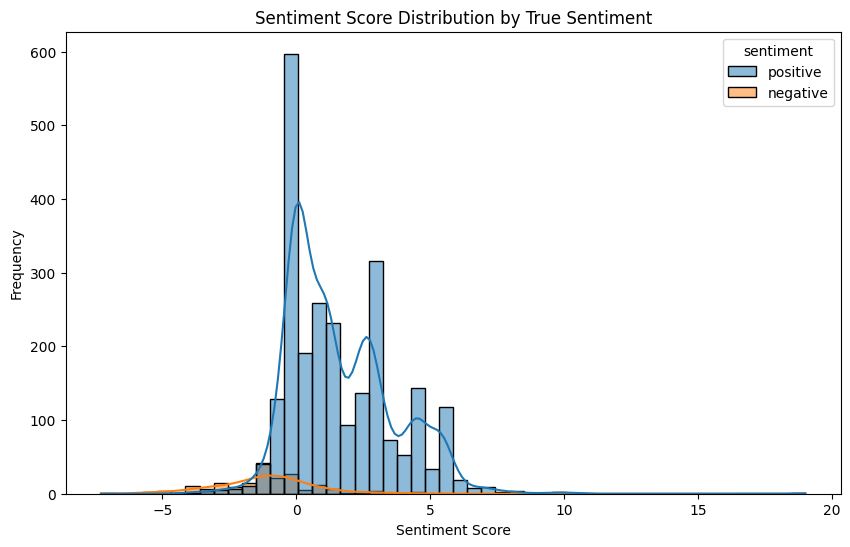


Tuning negative sentiment threshold...


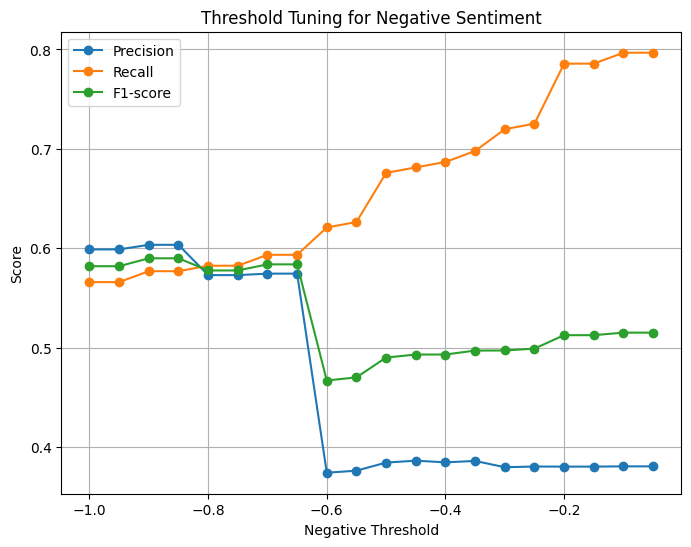

Best threshold by F1: -0.90
Precision: 0.60, Recall: 0.58, F1: 0.59
EXECUTING FINAL BINARY CLASSIFICATION ANALYSIS
=== FINAL BINARY CLASSIFICATION SCATTER ANALYSIS ===


=== FINAL BINARY CLASSIFICATION WORD CLOUD ANALYSIS ===


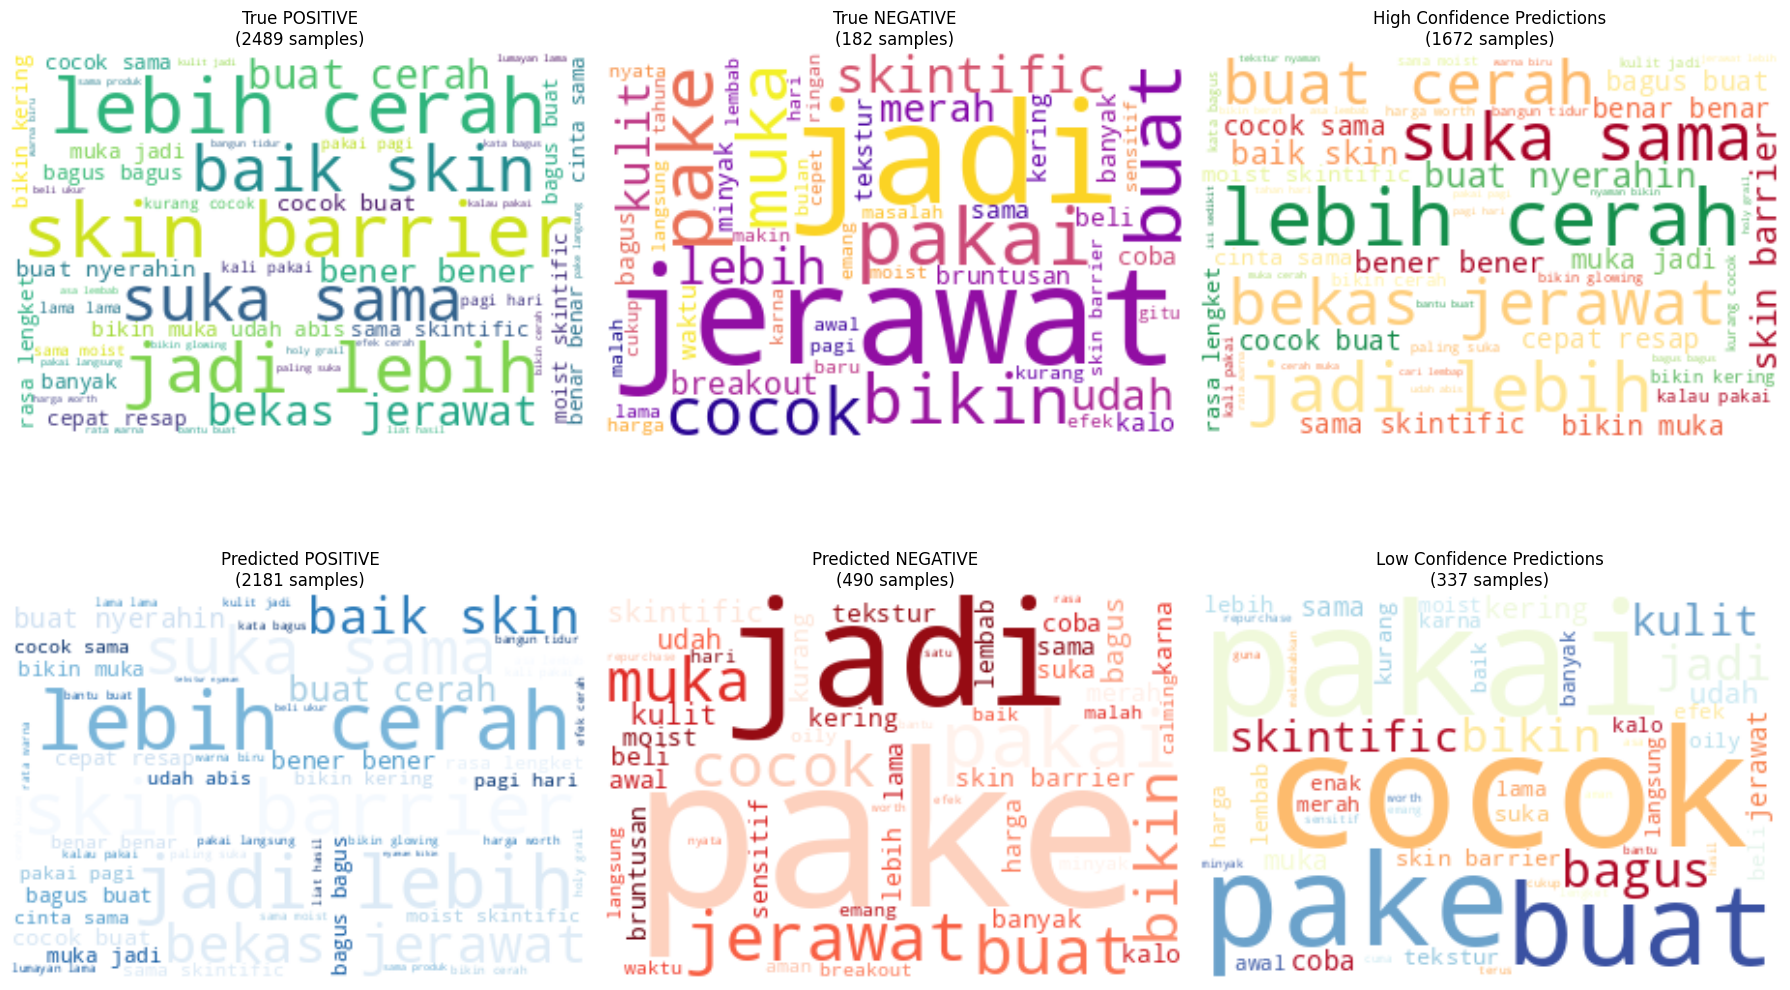


FINAL BINARY CLASSIFICATION SUMMARY
✓ Binary Classification Model Trained Successfully
✓ Training Accuracy: 0.9100 (91.0%)
✓ Test Accuracy: 0.8680 (86.8%)
✓ Classes: Positive vs Negative (Neutral removed)
✓ Enhanced Scatter Plot Visualizations Created
✓ Word Cloud Analysis Completed
✓ Model Performance Analysis Finished

Final Dataset Distribution:
  positive: 2489 samples (93.2%)
  negative: 182 samples (6.8%)

Model is ready for binary sentiment classification!


In [15]:
# Assuming df is your dataset with processed_text and sentiment
print("\nPlotting sentiment score distribution...")
df_scored = model.plot_sentiment_score_distribution(df)

print("\nTuning negative sentiment threshold...")
results_df = model.tune_negative_threshold(df_scored)

# Final Binary Classification Analysis with Enhanced Visualizations

def create_final_binary_scatter_analysis(model, df):
    """Create final comprehensive scatter plot analysis for binary classification"""
    if not model.is_trained:
        print("Model not trained. Cannot create final analysis.")
        return
        
    print("=== FINAL BINARY CLASSIFICATION SCATTER ANALYSIS ===")
    
    # Get comprehensive predictions and scores
    y_pred = model.model.predict(model.X_test_vectorized)
    y_pred_proba = model.model.predict_proba(model.X_test_vectorized)
    
    # Create enhanced scatter plots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=(
            'Prediction Confidence vs Accuracy',
            'Sentiment Score Distribution by True Class',
            'Model Uncertainty Analysis',
            'Class Separation Analysis',
            'Feature Importance Visualization',
            'Training vs Test Performance'
        ),
        specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Color mapping
    color_map = {'positive': '#1f77b4', 'negative': '#d62728'}
    
    # 1. Prediction Confidence vs Accuracy
    max_probs = np.max(y_pred_proba, axis=1)
    correct_predictions = (y_pred == model.y_test)
    
    # Create confidence bins
    conf_bins = np.linspace(0.5, 1.0, 11)
    bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
    accuracies = []
    
    for i in range(len(conf_bins)-1):
        mask = (max_probs >= conf_bins[i]) & (max_probs < conf_bins[i+1])
        if mask.sum() > 0:
            acc = correct_predictions[mask].mean()
        else:
            acc = 0
        accuracies.append(acc)
    
    fig.add_trace(
        go.Scatter(
            x=bin_centers,
            y=accuracies,
            mode='lines+markers',
            name='Confidence vs Accuracy',
            line=dict(color='blue', width=3),
            marker=dict(size=8)
        ),
        row=1, col=1
    )
    
    # 2. Sentiment Score Distribution by True Class
    if 'sentiment_score' in df.columns:
        for sentiment in ['positive', 'negative']:
            sentiment_scores = df[df['sentiment'] == sentiment]['sentiment_score']
            fig.add_trace(
                go.Histogram(
                    x=sentiment_scores,
                    name=f'True {sentiment}',
                    opacity=0.7,
                    marker_color=color_map[sentiment],
                    nbinsx=30
                ),
                row=1, col=2
            )
    
    # 3. Model Uncertainty Analysis (Prediction Probability Scatter)
    uncertainty = 1 - max_probs  # Higher uncertainty = lower max probability
    
    for sentiment in ['positive', 'negative']:
        mask = (model.y_test == sentiment)
        colors = ['green' if correct else 'red' for correct in correct_predictions[mask]]
        
        fig.add_trace(
            go.Scatter(
                x=max_probs[mask],
                y=uncertainty[mask],
                mode='markers',
                name=f'{sentiment} uncertainty',
                marker=dict(
                    color=colors,
                    opacity=0.6,
                    size=5
                ),
                hovertemplate=f'Confidence: %{{x:.3f}}<br>Uncertainty: %{{y:.3f}}<br>Class: {sentiment}<extra></extra>'
            ),
            row=1, col=3
        )
    
    # 4. Class Separation Analysis
    # Show probability of positive class for each true class
    pos_prob_idx = 1 if model.model.classes_[1] == 'positive' else 0
    pos_probs = y_pred_proba[:, pos_prob_idx]
    
    for sentiment in ['positive', 'negative']:
        mask = (model.y_test == sentiment)
        
        fig.add_trace(
            go.Scatter(
                x=np.where(mask)[0],
                y=pos_probs[mask],
                mode='markers',
                name=f'P(positive | True {sentiment})',
                marker=dict(
                    color=color_map[sentiment],
                    opacity=0.6,
                    size=4
                ),
                hovertemplate=f'Sample: %{{x}}<br>P(positive): %{{y:.3f}}<br>True: {sentiment}<extra></extra>'
            ),
            row=2, col=1
        )
    
    # 5. Feature Importance Visualization (Top features)
    if hasattr(model, 'model') and hasattr(model.model, 'feature_log_prob_'):
        feature_names = model.vectorizer.get_feature_names_out()
        feature_log_prob = model.model.feature_log_prob_
        
        # Get top 10 most discriminative features
        feature_diff = np.abs(feature_log_prob[0] - feature_log_prob[1])
        top_features_idx = np.argsort(feature_diff)[-10:]
        
        pos_scores = feature_log_prob[0][top_features_idx]
        neg_scores = feature_log_prob[1][top_features_idx]
        feature_names_top = feature_names[top_features_idx]
        
        fig.add_trace(
            go.Scatter(
                x=pos_scores,
                y=neg_scores,
                mode='markers+text',
                text=feature_names_top,
                textposition='top center',
                name='Feature Importance',
                marker=dict(size=8, color='purple'),
                hovertemplate='Feature: %{text}<br>Pos Score: %{x:.3f}<br>Neg Score: %{y:.3f}<extra></extra>'
            ),
            row=2, col=2
        )
    
    # 6. Training vs Test Performance Comparison
    train_pred = model.model.predict(model.X_train_vectorized)
    train_accuracy = accuracy_score(model.y_train, train_pred)
    test_accuracy = accuracy_score(model.y_test, y_pred)
    
    performance_data = {
        'Dataset': ['Training', 'Test'],
        'Accuracy': [train_accuracy, test_accuracy],
        'Size': [len(model.y_train), len(model.y_test)]
    }
    
    fig.add_trace(
        go.Scatter(
            x=performance_data['Size'],
            y=performance_data['Accuracy'],
            mode='markers+text',
            text=performance_data['Dataset'],
            textposition='top center',
            name='Train vs Test',
            marker=dict(size=[15, 12], color=['blue', 'red']),
            hovertemplate='Dataset: %{text}<br>Size: %{x}<br>Accuracy: %{y:.4f}<extra></extra>'
        ),
        row=2, col=3
    )
    
    # Update layout
    fig.update_layout(
        title_text="Final Binary Classification Analysis - Comprehensive Scatter Plots",
        height=800,
        showlegend=True
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Confidence Level", row=1, col=1)
    fig.update_yaxes(title_text="Accuracy", row=1, col=1)
    
    fig.update_xaxes(title_text="Sentiment Score", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    
    fig.update_xaxes(title_text="Confidence", row=1, col=3)
    fig.update_yaxes(title_text="Uncertainty", row=1, col=3)
    
    fig.update_xaxes(title_text="Sample Index", row=2, col=1)
    fig.update_yaxes(title_text="P(Positive)", row=2, col=1)
    
    fig.update_xaxes(title_text="Positive Class Score", row=2, col=2)
    fig.update_yaxes(title_text="Negative Class Score", row=2, col=2)
    
    fig.update_xaxes(title_text="Dataset Size", row=2, col=3)
    fig.update_yaxes(title_text="Accuracy", row=2, col=3)
    
    fig.show()

def create_final_wordcloud_analysis(model, df):
    """Create final word cloud analysis for binary classification"""
    if not model.is_trained:
        print("Model not trained. Cannot create word cloud analysis.")
        return
        
    print("=== FINAL BINARY CLASSIFICATION WORD CLOUD ANALYSIS ===")
    
    # Get model predictions on the full dataset
    text_col = 'processed_text' if 'processed_text' in df.columns else 'review'
    predictions = model.pipeline.predict(df[text_col])
    
    # Create comprehensive word clouds
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # True positive and negative
    for i, sentiment in enumerate(['positive', 'negative']):
        true_mask = df['sentiment'] == sentiment
        true_text = ' '.join(df[true_mask][text_col].astype(str))
        
        if len(true_text.strip()) > 0:
            colormap = 'viridis' if sentiment == 'positive' else 'plasma'
            wordcloud = WordCloud(width=300, height=200, background_color='white',
                                colormap=colormap, max_words=50).generate(true_text)
            axes[0, i].imshow(wordcloud, interpolation='bilinear')
            axes[0, i].set_title(f'True {sentiment.upper()}\n({true_mask.sum()} samples)')
        else:
            axes[0, i].text(0.5, 0.5, 'No data', ha='center', va='center')
            axes[0, i].set_title(f'True {sentiment.upper()}')
        axes[0, i].axis('off')
    
    # Predicted positive and negative
    for i, sentiment in enumerate(['positive', 'negative']):
        pred_mask = predictions == sentiment
        pred_text = ' '.join(df[pred_mask][text_col].astype(str))
        
        if len(pred_text.strip()) > 0:
            colormap = 'Blues' if sentiment == 'positive' else 'Reds'
            wordcloud = WordCloud(width=300, height=200, background_color='white',
                                colormap=colormap, max_words=50).generate(pred_text)
            axes[1, i].imshow(wordcloud, interpolation='bilinear')
            axes[1, i].set_title(f'Predicted {sentiment.upper()}\n({pred_mask.sum()} samples)')
        else:
            axes[1, i].text(0.5, 0.5, 'No data', ha='center', va='center')
            axes[1, i].set_title(f'Predicted {sentiment.upper()}')
        axes[1, i].axis('off')
    
    # High confidence predictions
    y_pred_proba = model.pipeline.predict_proba(df[text_col])
    max_probs = np.max(y_pred_proba, axis=1)
    high_conf_mask = max_probs >= 0.8
    
    if high_conf_mask.sum() > 0:
        high_conf_text = ' '.join(df[high_conf_mask][text_col].astype(str))
        wordcloud = WordCloud(width=300, height=200, background_color='white',
                            colormap='RdYlGn', max_words=50).generate(high_conf_text)
        axes[0, 2].imshow(wordcloud, interpolation='bilinear')
        axes[0, 2].set_title(f'High Confidence Predictions\n({high_conf_mask.sum()} samples)')
    else:
        axes[0, 2].text(0.5, 0.5, 'No high\nconfidence\npredictions', ha='center', va='center')
        axes[0, 2].set_title('High Confidence Predictions')
    axes[0, 2].axis('off')
    
    # Low confidence predictions
    low_conf_mask = max_probs <= 0.6
    
    if low_conf_mask.sum() > 0:
        low_conf_text = ' '.join(df[low_conf_mask][text_col].astype(str))
        wordcloud = WordCloud(width=300, height=200, background_color='white',
                            colormap='RdYlBu', max_words=50).generate(low_conf_text)
        axes[1, 2].imshow(wordcloud, interpolation='bilinear')
        axes[1, 2].set_title(f'Low Confidence Predictions\n({low_conf_mask.sum()} samples)')
    else:
        axes[1, 2].text(0.5, 0.5, 'No low\nconfidence\npredictions', ha='center', va='center')
        axes[1, 2].set_title('Low Confidence Predictions')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Execute final comprehensive analysis
if 'model' in locals() and model.is_trained and len(df) > 0:
    print("="*60)
    print("EXECUTING FINAL BINARY CLASSIFICATION ANALYSIS")
    print("="*60)
    
    # Create final scatter plot analysis
    create_final_binary_scatter_analysis(model, df)
    
    # Create final word cloud analysis
    create_final_wordcloud_analysis(model, df)
    
    # Print final summary
    print("\n" + "="*60)
    print("FINAL BINARY CLASSIFICATION SUMMARY")
    print("="*60)
    
    test_accuracy = accuracy_score(model.y_test, model.model.predict(model.X_test_vectorized))
    train_accuracy = accuracy_score(model.y_train, model.model.predict(model.X_train_vectorized))
    
    print(f"✓ Binary Classification Model Trained Successfully")
    print(f"✓ Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.1f}%)")
    print(f"✓ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
    print(f"✓ Classes: Positive vs Negative (Neutral removed)")
    print(f"✓ Enhanced Scatter Plot Visualizations Created")
    print(f"✓ Word Cloud Analysis Completed")
    print(f"✓ Model Performance Analysis Finished")
    
    # Dataset statistics
    final_dist = df['sentiment'].value_counts()
    print(f"\nFinal Dataset Distribution:")
    for sentiment, count in final_dist.items():
        percentage = (count / len(df)) * 100
        print(f"  {sentiment}: {count} samples ({percentage:.1f}%)")
    
    print(f"\nModel is ready for binary sentiment classification!")
    print("="*60)

else:
    print("Model not trained or data not available. Please run all previous cells first.")

